In [392]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw; import scipy.stats
import math

# Everything together - 13 MFCCs

In [393]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)
        
        for j in range(mfcc.shape[1]):
            new_val = (mfcc[i, j]-mean)/sd
            if new_val > 2:
                new_val == 2
            if new_val < -2:
                new_val == -2
            matrix[i, j] = new_val/5 + 0.5
    return matrix

# print(normalize(np.array([[-3, -2, -1], [3, 2, 3]])))

In [394]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [395]:
def remove_short_pauses(speech_array, min_pause_len_s, mfcc_len_s): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(len(sp_transitions)-1):
        if (sp_transitions[t+1] - sp_transitions[t])*mfcc_len_s < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+1]] = [1]*(sp_transitions[t+1]-sp_transitions[t])
            
    return speech_array

In [396]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', 30)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(smooth_query[int(samplerate*0.5): int(samplerate*1.5)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [397]:
def calc_path_len(alignment):

    counter = 0
    for i in alignment.stepsTaken:
        if i == 1:
            counter = counter + 1
    return counter*math.sqrt(2)+len(alignment.stepsTaken)-counter

In [398]:
def plot_all_mfccs(mfcc1_normal, mfcc2_normal):
    time1 = np.linspace(0, mfcc1_normal.shape[1], num = mfcc1_normal.shape[1])   
    plt.figure(figsize=(10,3))
    for i in mfcc1_normal:
        plt.plot(time1, i);   
    
    time1 = np.linspace(0, mfcc2_normal.shape[1], num = mfcc2_normal.shape[1])
    plt.figure(figsize=(10,3))
    for i in mfcc2_normal:
        plt.plot(time1, i);   

In [399]:
def create_smooth_x(fragment_x, frame_per_window):
    smooth_x = [] # Store smoothened sample array    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num) 
    return smooth_x

In [400]:
def plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s):
    if timelst1 and timelst2:              # plot where the segments are on the bigger alignment curve plot
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 

In [401]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, alpha, csv_matrix):
    
#     theta = math.atan(alignment.M/alignment.N)  # angle of diagonal = length of y axis over length of x axis
    theta = math.atan(1)
    
    overall_stretch = 0
    overall_arclen = 0
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if i % alpha == 0:
                if xs[i+1]-xs[i] == 0:
                    rho_i = math.pi/2
                else:
                    rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

                dev_rho_i = deviation(rho_i, theta)
                stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
                
                overall_stretch = overall_stretch + stretch
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_arclen = overall_arclen + arclen            
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
        
        common_seg_dict[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        csv_matrix[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        
    return overall_arclen, overall_stretch

In [402]:
def plot_alignment_curve_marked_with_segments(xs, ys, path_indices):   # plot the alignment curve marked with segments
    plot_ratio = max(xs) // 10
    plt.figure(figsize=(max(xs)/plot_ratio, max(ys)/plot_ratio)) 
    plt.plot(xs, ys, linewidth=1)
    plt.plot([0, max(xs)], [0, max(ys)])
    
    for k in range(len(path_indices)):
        x_axis = xs[path_indices[k]]
        y_axis = ys[path_indices[k]]
        plt.scatter(x_axis, y_axis, color = 'black')

In [403]:
def calc_seg_len(common_seg_dict):
    for i in common_seg_dict:
        if i != len(common_seg_dict):
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][1])-float(common_seg_dict[i][1])))
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][2])-float(common_seg_dict[i][2])))

In [404]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    segments = kwargs.get('segments', segments1)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', 30)    
    min_pause_len_s = input_min_pause /1000     

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)
    frame_per_window = sr1 * window_len/1000 # Smoothen amplitude values in x
    
    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1])     
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])    
    
    mfcc_len_s = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc 
    alpha = kwargs.get('alpha', mfcc_len_s*1000)
#     print(mfcc_len_s)
    
    mfcc1_normal = normalize(mfcc1) # normalize each mfcc
    mfcc2_normal = normalize(mfcc2)
#     plot_all_mfccs(mfcc1_normal, mfcc2_normal); # plot all MFCCS    
    
    alignment = dtw(mfcc1_normal.T, mfcc2_normal.T, step_pattern = 'symmetric1', dist_method = 'euclidean', keep_internals=True)
    alignment.plot('threeway')
#     plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s)   
    
    smooth_x = create_smooth_x(fragment_x, frame_per_window)       
    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, input_min_amp = threshold1, input_min_pause = input_min_pause)  
    speech_x = remove_short_pauses(speech_x, min_pause_len_s, mfcc_len_s)
    
    xs = alignment.index1
    ys = alignment.index2 
    
    seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix = return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s, segments)
    
    # plot speech_x, smooth_x, and segmentation results on y    
    plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict)
    

    calc_seg_len(common_seg_dict)
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
    csv_matrix.pop(len(csv_matrix)) # remove the last pause segment
    
   
    overall_arclen, overall_stretch = stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, int(alpha/(mfcc_len_s*1000)), csv_matrix)
    
    print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen)  
    plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment)    # check mfcc alignment results, plot each aligned mfcc    
    print_output_matrix(common_seg_dict, csv_matrix, file1, file2)
    
#     plot_alignment_curve_marked_with_segments(xs, ys, path_indices)   # plot the alignment curve marked with segments

In [405]:
def print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen):
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))
    print('Distance  = %3.2f' % (alignment.distance/math.sqrt(num_of_mfcc)/calc_path_len(alignment)))

In [406]:
def plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment):
    avg_corr = []
    for k in range(num_of_mfcc):        
        plot_x = []
        plot_y = []

        for i in range(len(alignment.index1)):
            plot_x.append(mfcc1_normal.T[alignment.index1[i]][k])
            plot_y.append(mfcc2_normal.T[alignment.index2[i]][k])

#         plt.subplots(1, 1) 
#         plt.scatter(plot_x, plot_y, color = 'black')
#         plt.title(label= 'MFCC ' + str(k+1) + '. Pearson r = %3.2f' % scipy.stats.pearsonr(plot_x, plot_y)[0])
        avg_corr.append(scipy.stats.pearsonr(plot_x, plot_y)[0])
    
    print('Correlation = %3.2f' %np.average(avg_corr))

In [407]:
def plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 8)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)

    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    

    ax5.plot(time, fragment_y)
    ax5.set_xticks(xticks)      

    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1
        

In [408]:
def return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s, segments):
    
    xs = alignment.index1
    ys = alignment.index2
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                      
    # length of path = len(path[0]) = len(path[1])

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    csv_matrix = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    
    seg_index = 0

    counter = 0    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve

        if speech_x[i] != speech_x[i+1]:
            
            seg = segments[counter]
            counter = counter + 1
            
#             if speech_x[i] == 0:                #speech segment starts
#                 seg = "voice"
#             if speech_x[i] == 1:                # pause segment starts
#                 seg = "pause"

            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x. max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            csv_matrix[seg_index+1] = [seg]
            
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix

# Plot each MFCC

In [409]:
def print_output_matrix(common_seg_dict, csv_matrix, file1, file2):
    df1 = pd.DataFrame(common_seg_dict)
    df1.index = ['seg', 'start 1', 'start 2', 'len 1', 'len 2','stretch']
#     pd.options.display.float_format = "{:,.2f}".format
    display(df1)
    df = pd.DataFrame(csv_matrix)    


    df.index = ['seg', 'stretch']
    display(df)
    filename = '/Users/ninismacbook/desktop/' + file1.replace('.wav','').replace('report-', '') + file2.replace('.wav','').replace('report-', '') + '.csv' 
    df.to_csv(filename)

# words

In [410]:
window_len = 30
hop_len_in_s = 0.01 # set hop_length = __ s. Number of mfcc frames = audio length * samplerate / hop length (default = 512)
# mfcc_len_s

segments1 = ['We', 'pause', 'have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']
segments2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']

segmentsnormal2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'projec', 'pause', 't','','','','','','']
segmentsnormal3 = ['We', 'pause', 'have', 'pause', 'really', 'pause', 'en', 'pause', 'joyed','pause', 'the','pause', 'pro', 'pause', 'ject','','','','','','']
segmentspause1 = ['We have', 'pause', 'really', 'pause', 'enjoyed', 'pause', 'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentspause2 = ['We', 'pause', 'have', 'pause', 'rea','pause','lly', 'pause', 'en', 'pause','joyed','pause' ,'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentslongword2 = ['We', 'pause', 'have', 'pause', 'rea','pause','lly', 'pause', 'en', 'pause','joyed','pause','the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentscombo1 = ['We', 'pause', 'have', 'pause', 'really','pause', 'en', 'pause','joyed','pause','the','pause', 'project','pause', '','','','','','']

# We have really enjoyed the project - by word, normal1

# 1. normal1normal2

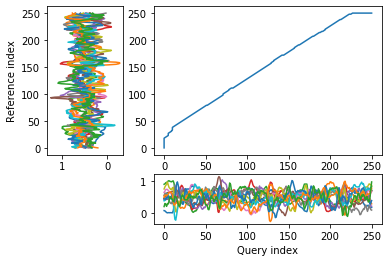

Stretch = 0.08
Distance  = 0.10
Correlation = 0.78


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  1.89841  2.00797  2.05777  2.23705    2.40637  3.01394  3.09363   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.11     0.05     0.18     0.17       0.61     0.08     0.28   
stretch     0.00     0.00     0.00     0.04       0.06     0.11     0.10   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  3.37251  3.52191  3.57171   3.7012  
len 1       0.16     0.06     0.14     0.35  
len 2       0.15     0.05     0.13     0.29  
stretch     0.05     0.15     0.16     0.11

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.00   0.00  0.00   0.04       0.06   0.11   0.10   0.05  0.15   

            10       11  
seg      pause  project  
stretch   0.16     0.11

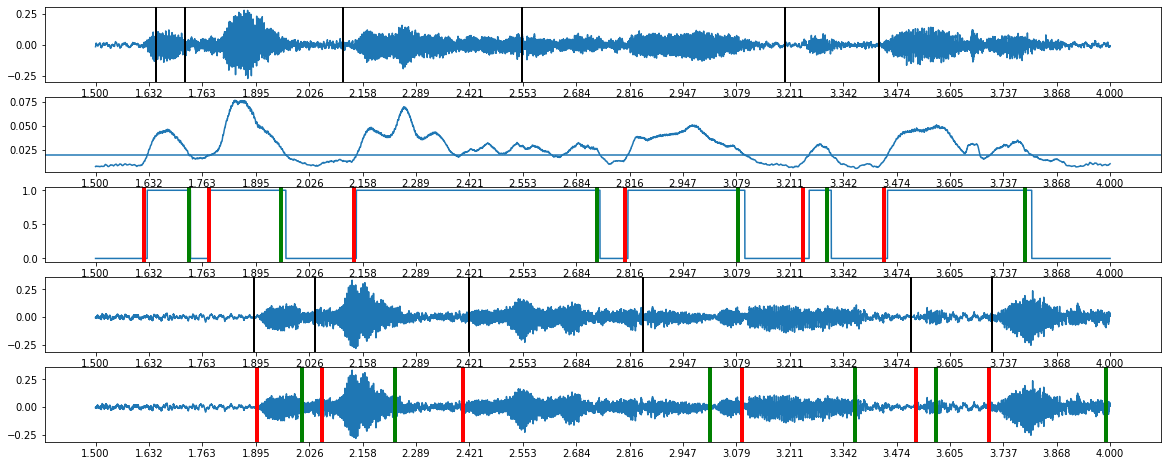

In [411]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.02, 
      timelst1=timelst1, timelst2 = timelst2) # unit for input_min_pause and alpha = ms 

# 8. normal1normal3

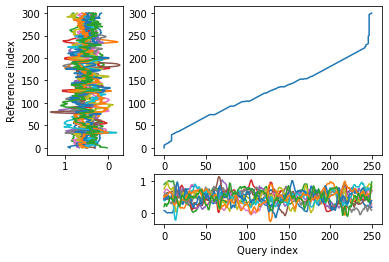

Stretch = 0.13
Distance  = 0.11
Correlation = 0.77


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  1.31873  1.41833  1.46813  1.64741    1.76693   2.2251  2.28486   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.10     0.05     0.18     0.12       0.46     0.06     0.19   
stretch     0.07     0.00     0.00     0.28       0.18     0.12     0.26   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2   2.4741  2.56375  2.61355  2.75299  
len 1       0.16     0.06     0.14     0.35  
len 2       0.09     0.05     0.14     0.35  
stretch     0.38     0.15     0.00     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.07   0.00  0.00   0.28       0.18   0.12   0.26   0.38  0.15   

            10       11  
seg      pause  project  
stretch   0.00     0.00

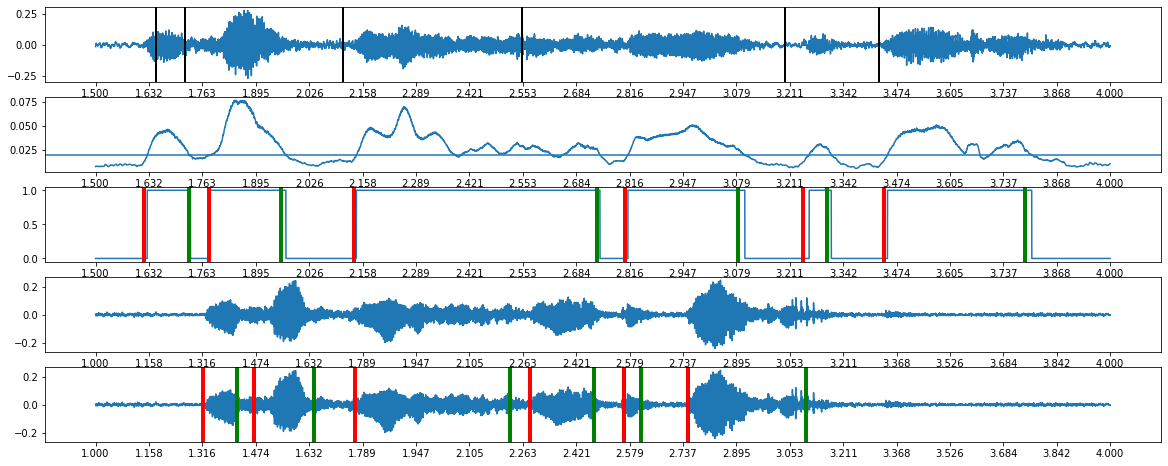

In [412]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.02, 
      timelst1=timelst1) # unit for input_min_pause and alpha = ms 

# 9. normal2normal3

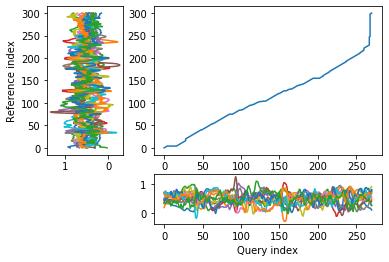

Stretch = 0.14
Distance  = 0.11
Correlation = 0.77


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90849   2.2572    2.39668  2.96458  3.03432  3.39299  3.54244   
start 2  1.32878  1.65756     1.7572  2.18561  2.24539  2.50443  2.57417   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.33     0.10       0.43     0.06     0.26     0.07     0.06   
stretch     0.04     0.24       0.19     0.12     0.22     0.49     0.15   

               8        9  
seg        pause  project  
start 1  3.59225  3.71181  
start 2  2.63395  2.76347  
len 1       0.12     0.40  
len 2       0.13     0.47  
stretch     0.06     0.11

1      2          3      4      5      6     7      8        9
seg      We have  pause  really en  pause  joyed  pause   the  pause  project
stretch     0.04   0.24       0.19   0.12   0.22   0.49  0.15   0.06     0.11

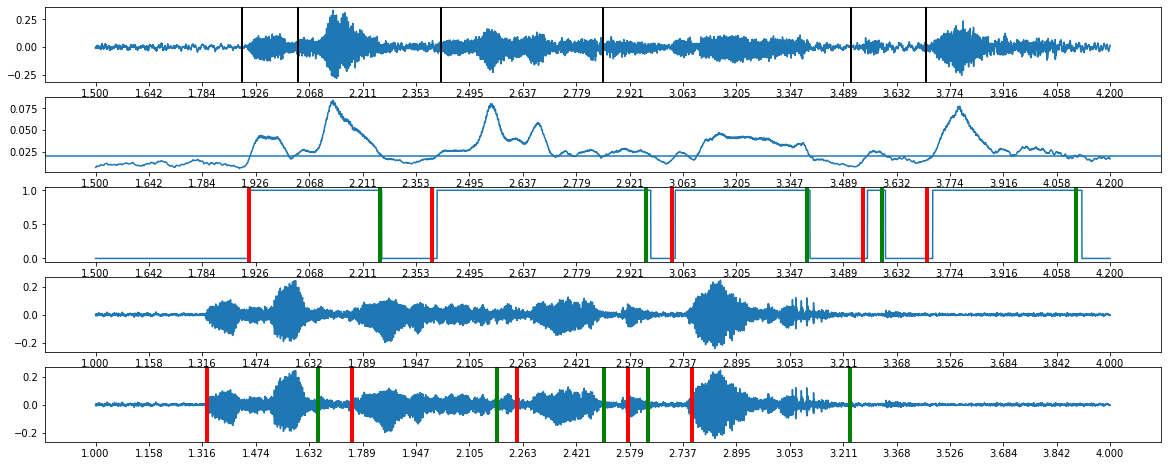

In [413]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 4.2
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1=0.02, timelst1 = timelst1, segments = segments2) # unit for input_min_pause and alpha = ms 

# 2. normal1pause1

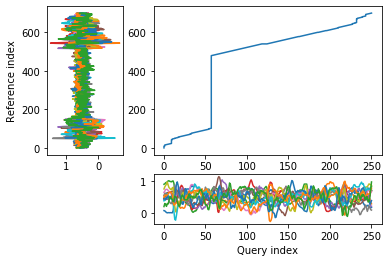

Stretch = 0.87
Distance  = 0.15
Correlation = 0.53


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  1.97809  2.11753  2.16733  2.38645    6.34064  6.87849  6.94821   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.14     0.05     0.22     3.95       0.54     0.07     0.28   
stretch     0.18     0.00     0.14     0.94       0.06     0.00     0.00   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  7.22709  7.37649  7.43625  7.56574  
len 1       0.16     0.06     0.14     0.35  
len 2       0.15     0.06     0.13     0.39  
stretch     0.05     0.00     0.06     0.11

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.18   0.00  0.14   0.94       0.06   0.00   0.00   0.05  0.00   

            10       11  
seg      pause  project  
stretch   0.06     0.11

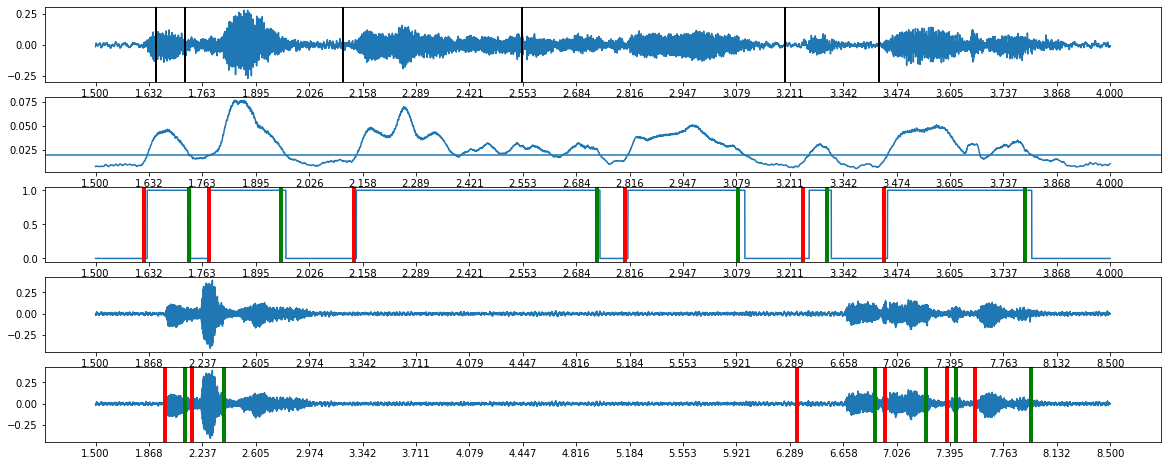

In [414]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1)

# 3. normal1pause2

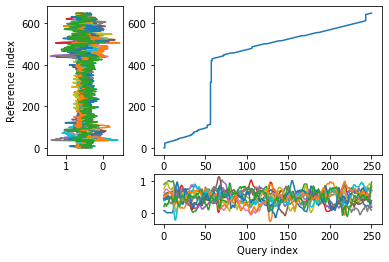

Stretch = 0.85
Distance  = 0.13
Correlation = 0.69


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  2.34861  2.49801  2.55777  2.90637    6.34263        7  7.06972   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.15     0.06     0.35     3.44       0.66     0.07     0.25   
stretch     0.22     0.15     0.41     0.93       0.18     0.00     0.08   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  7.31873  7.44821  7.50797  7.62749  
len 1       0.16     0.06     0.14     0.35  
len 2       0.13     0.06     0.12     0.35  
stretch     0.15     0.00     0.11     0.00

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.22   0.15  0.41   0.93       0.18   0.00   0.08   0.15  0.00   

            10       11  
seg      pause  project  
stretch   0.11     0.00

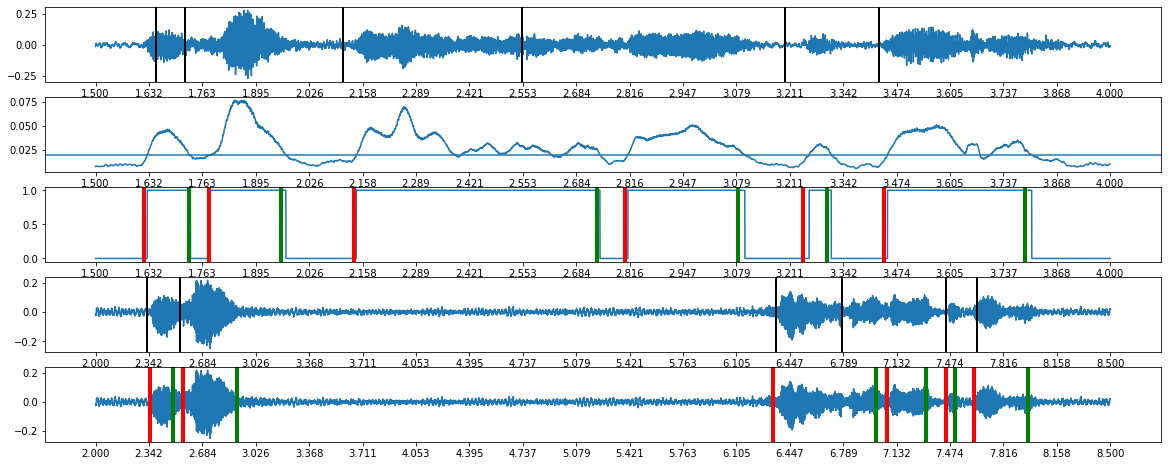

In [415]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 4. normal1longword1

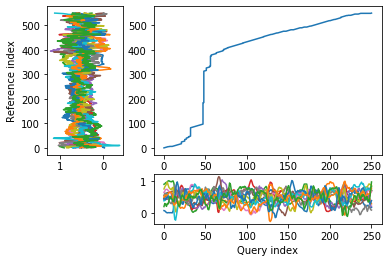

Stretch = 0.87
Distance  = 0.13
Correlation = 0.69


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  1.57968  1.75896  1.90837  2.45618     5.3745  6.06175  6.12151   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.18     0.15     0.55     2.92       0.69     0.06     0.21   
stretch     0.33     0.64     0.61     0.92       0.10     0.12     0.20   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  6.33068  6.44024  6.49004  6.62948  
len 1       0.16     0.06     0.14     0.35  
len 2       0.11     0.05     0.14     0.31  
stretch     0.26     0.15     0.00     0.17

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.33   0.64  0.61   0.92       0.10   0.12   0.20   0.26  0.15   

            10       11  
seg      pause  project  
stretch   0.00     0.17

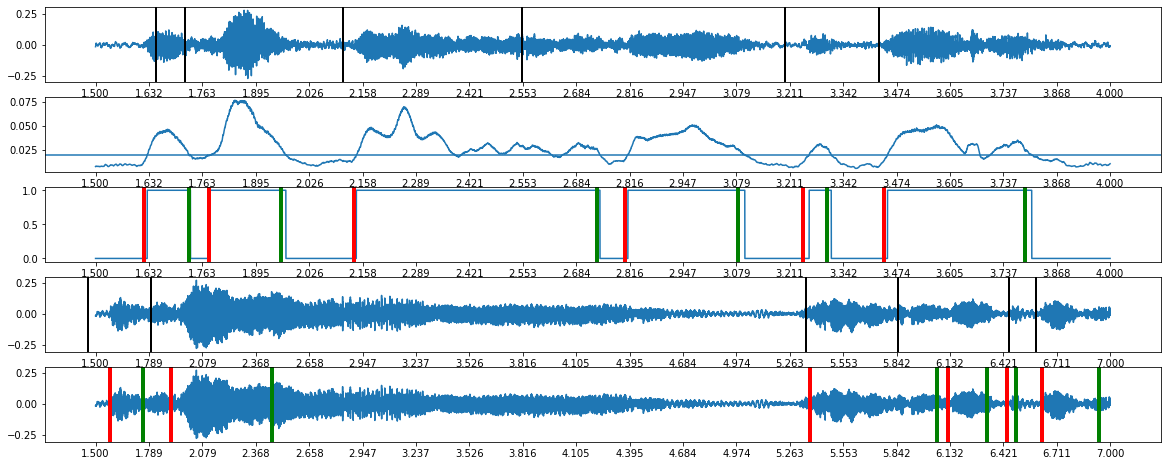

In [416]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 5. normal1longword2

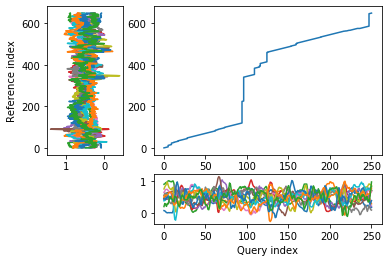

Stretch = 0.72
Distance  = 0.13
Correlation = 0.71


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  1.75896  1.89841  1.94821  2.15737    2.36653  5.63347  6.16135   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.14     0.05     0.21     0.21       3.27     0.53     0.29   
stretch     0.18     0.00     0.11     0.11       0.76     0.84     0.03   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2   6.4502  6.67928  6.73904  6.88845  
len 1       0.16     0.06     0.14     0.35  
len 2       0.23     0.06     0.15     0.32  
stretch     0.25     0.00     0.05     0.06

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.18   0.00  0.11   0.11       0.76   0.84   0.03   0.25  0.00   

            10       11  
seg      pause  project  
stretch   0.05     0.06

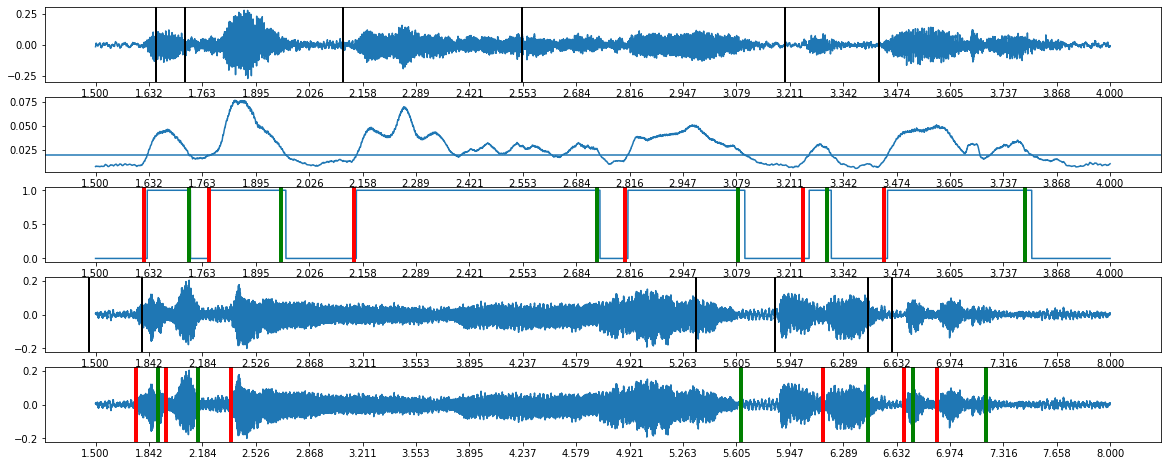

In [417]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.46, 1.80, 5.35, 5.85, 6.45, 6.6]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 6. normal1combo1

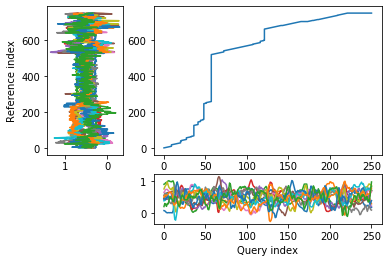

Stretch = 0.82
Distance  = 0.14
Correlation = 0.60


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2   1.6992  1.92829  2.06773  3.04382    6.73904  8.11355  8.18327   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.23     0.14     0.98     3.70       1.37     0.07     0.26   
stretch     0.46     0.61     0.77     0.94       0.48     0.00     0.05   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  8.44223  8.52191  8.57171   8.7012  
len 1       0.16     0.06     0.14     0.35  
len 2       0.08     0.05     0.13     0.27  
stretch     0.45     0.15     0.06     0.20

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.46   0.61  0.77   0.94       0.48   0.00   0.05   0.45  0.15   

            10       11  
seg      pause  project  
stretch   0.06     0.20

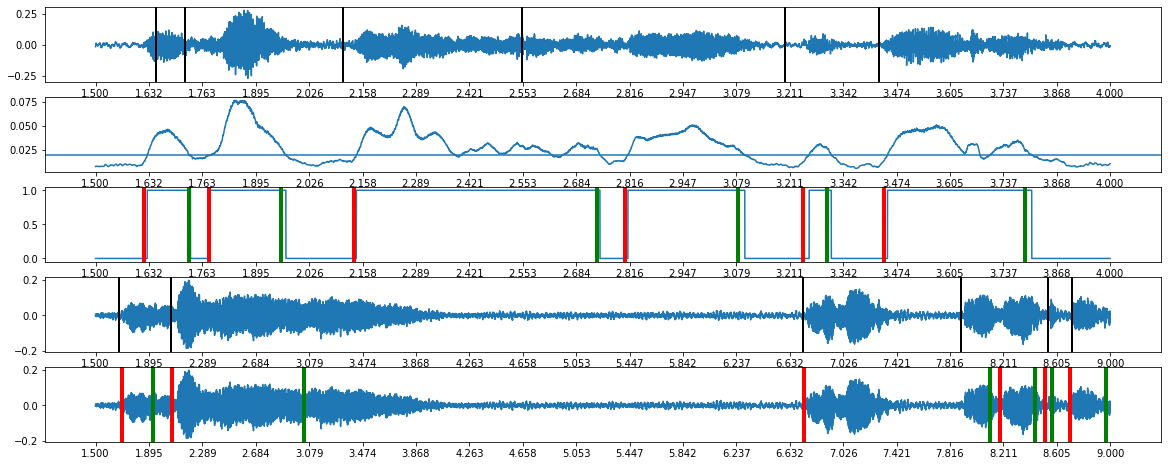

In [418]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 7. normal1combo2

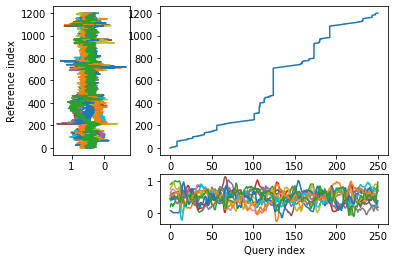

Stretch = 0.77
Distance  = 0.15
Correlation = 0.65


1        2        3        4          5        6        7   \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.61952  1.72908  1.77888  1.95817    2.13745  2.73506  2.80478   
start 2  2.62749  2.81673  2.98606  3.39442    4.08167  6.65139  9.14143   
len 1       0.11     0.05     0.18     0.18       0.60     0.07     0.28   
len 2       0.19     0.17     0.41     0.69       2.57     2.49     0.40   
stretch     0.36     0.68     0.49     0.68       0.70     0.97     0.24   

              8        9        10       11  
seg        pause      the    pause  project  
start 1  3.08367  3.24303  3.30279  3.44223  
start 2  9.53984  11.2829  11.6414  12.8267  
len 1       0.16     0.06     0.14     0.35  
len 2       1.74     0.36     1.19     0.38  
stretch     0.88     0.81     0.85     0.06

1      2     3      4          5      6      7      8     9   \
seg        We  pause  have  pause  really en  pause  joyed  pause   the   
stretch  0.36   0.68  0.49   0.68       0.70   0.97   0.24   0.88  0.81   

            10       11  
seg      pause  project  
stretch   0.85     0.06

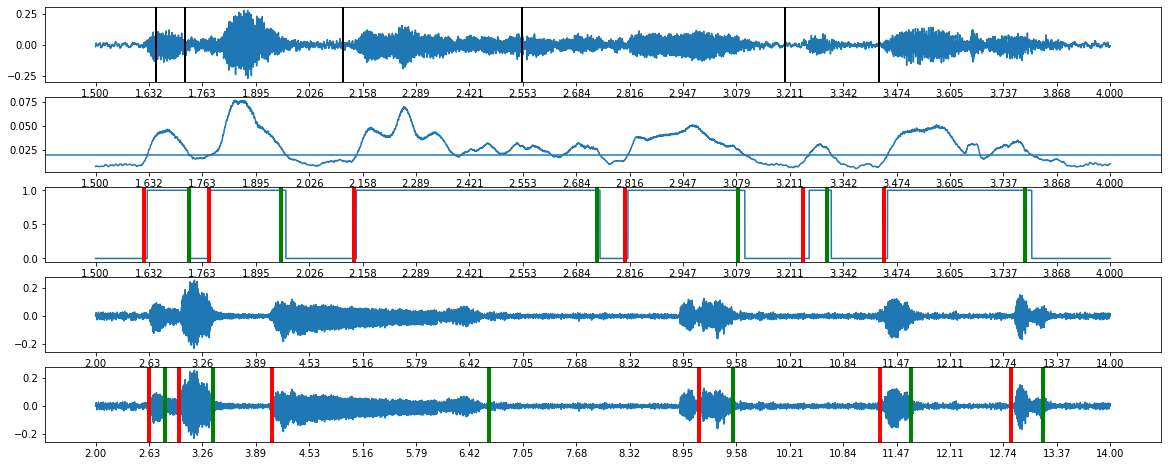

In [419]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, 
       threshold1 = 0.02, timelst1=timelst1)

# 10. normal2pause1

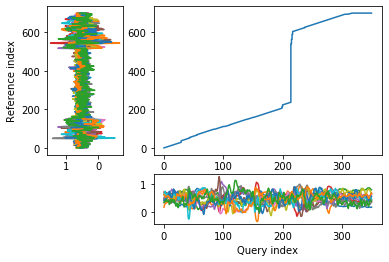

Stretch = 0.90
Distance  = 0.14
Correlation = 0.49


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2   1.9886  2.38746    2.50712  3.04558  3.10541  3.46439   3.7735   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.40     0.12       0.54     0.06     0.36     0.31     0.05   
stretch     0.09     0.11       0.06     0.12     0.00     0.45     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2  3.82336  7.57265  7.99145  8.07123  
len 1       0.12     0.40     0.08     0.10  
len 2       3.75     0.42     0.08     0.10  
stretch     0.96     0.03     0.00     0.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.09   0.11       0.06   0.12   0.00   0.45  0.00   0.96    0.03   

            10    11  
seg      pause     t  
stretch   0.00  0.00

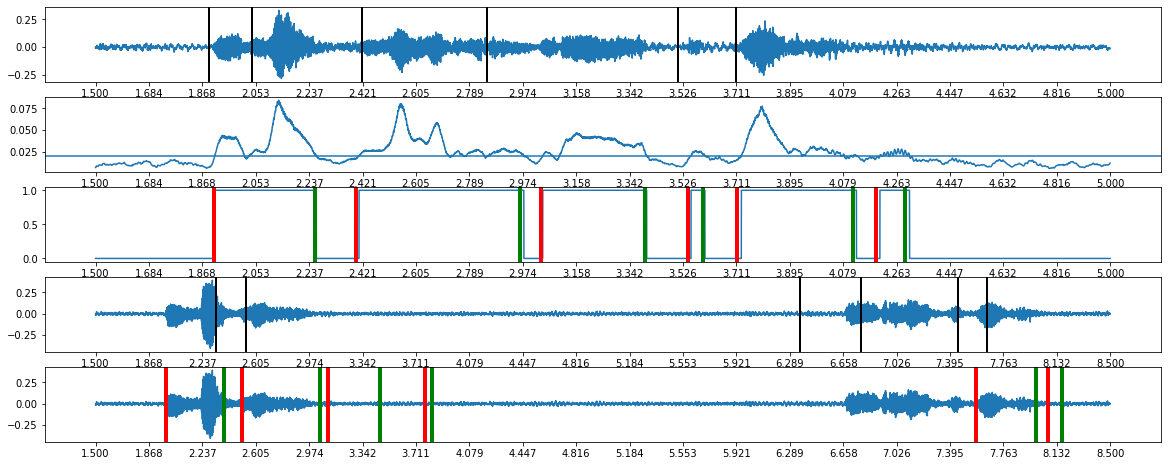

In [420]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 11. normal2pause2

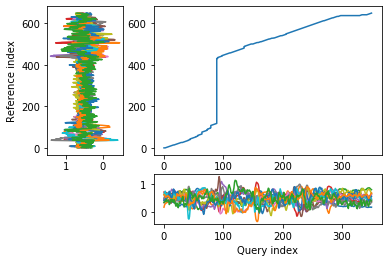

Stretch = 0.81
Distance  = 0.12
Correlation = 0.73


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  2.35897  2.92735    6.29772  6.99573  7.03561  7.32479  7.45442   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.57     3.37       0.70     0.04     0.29     0.13     0.07   
stretch     0.31     0.95       0.16     0.41     0.15     0.11     0.26   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2  7.52422  7.64387  8.04274  8.11254  
len 1       0.12     0.40     0.08     0.10  
len 2       0.12     0.40     0.07     0.10  
stretch     0.00     0.00     0.00     0.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.31   0.95       0.16   0.41   0.15   0.11  0.26   0.00    0.00   

            10    11  
seg      pause     t  
stretch   0.00  0.00

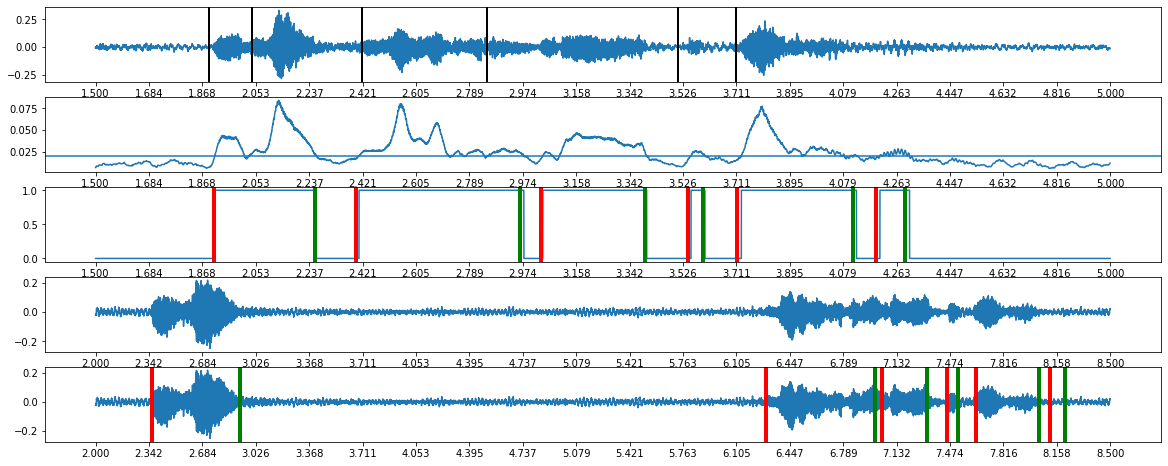

In [421]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentsnormal2)

# 12. normal2longword1

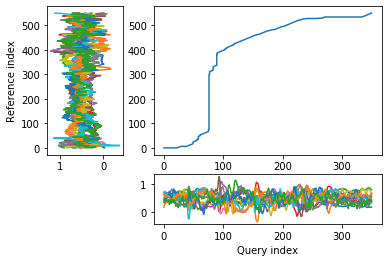

Stretch = 0.88
Distance  = 0.15
Correlation = 0.56


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  1.58974  2.24786    5.31909  6.01709  6.08689  6.34615  6.47578   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.66     3.07       0.70     0.07     0.26     0.13     0.05   
stretch     0.39     0.94       0.14     0.00     0.22     0.11     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2  6.52564   6.6453  6.77493  6.81481  
len 1       0.12     0.40     0.08     0.10  
len 2       0.12     0.13     0.04     0.01  
stretch     0.00     0.59     0.49     0.85

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.39   0.94       0.14   0.00   0.22   0.11  0.00   0.00    0.59   

            10    11  
seg      pause     t  
stretch   0.49  0.85

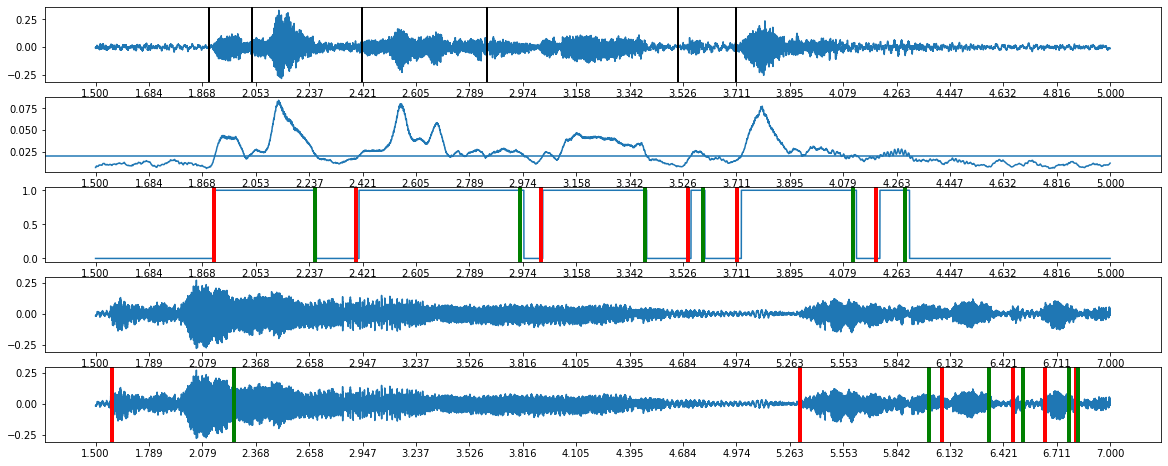

In [422]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentsnormal2)

# 13. normal2longword2

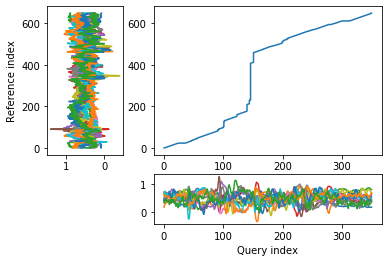

Stretch = 0.62
Distance  = 0.14
Correlation = 0.67


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2   1.7792  2.16809    2.30769  5.57835  6.10684  6.45584  6.69516   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.39     0.14       3.27     0.53     0.35     0.24     0.09   
stretch     0.08     0.00       0.77     0.84     0.06     0.37     0.41   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2   6.7849  6.90456   7.2735  7.35328  
len 1       0.12     0.40     0.08     0.10  
len 2       0.12     0.37     0.08     0.08  
stretch     0.00     0.06     0.00     0.08

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.08   0.00       0.77   0.84   0.06   0.37  0.41   0.00    0.06   

            10    11  
seg      pause     t  
stretch   0.00  0.08

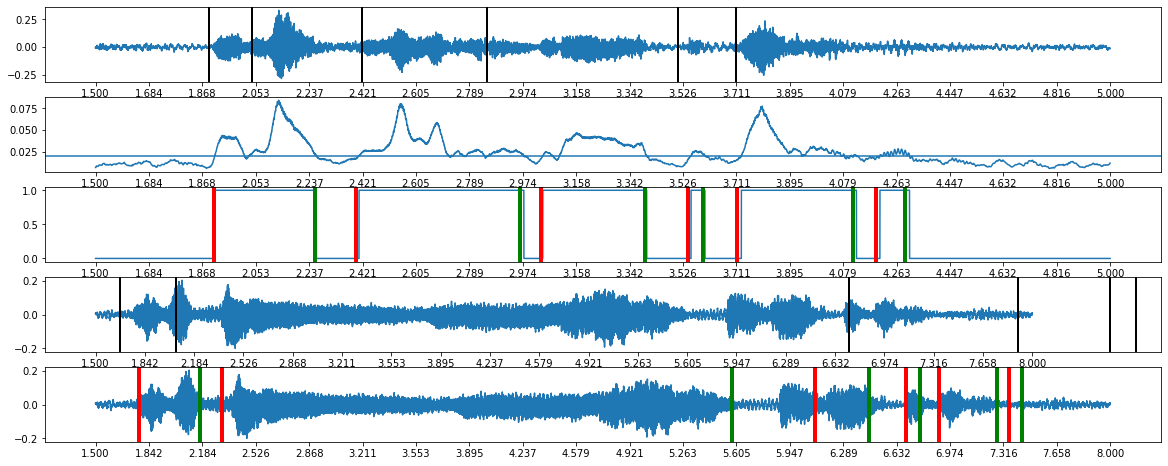

In [423]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 14. normal2combo1

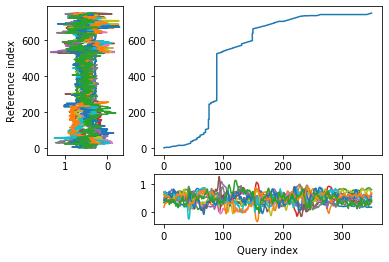

Stretch = 0.84
Distance  = 0.15
Correlation = 0.54


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  1.71937  3.08547    6.73504  7.43305  8.14103  8.48006  8.54986   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       1.37     3.65       0.70     0.71     0.34     0.07     0.05   
stretch     0.68     0.95       0.14     0.88     0.08     0.49     0.00   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2  8.59972  8.71937  8.87892  8.89886  
len 1       0.12     0.40     0.08     0.10  
len 2       0.12     0.16     0.02     0.00  
stretch     0.00     0.53     0.64     1.00

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.68   0.95       0.14   0.88   0.08   0.49  0.00   0.00    0.53   

            10    11  
seg      pause     t  
stretch   0.64  1.00

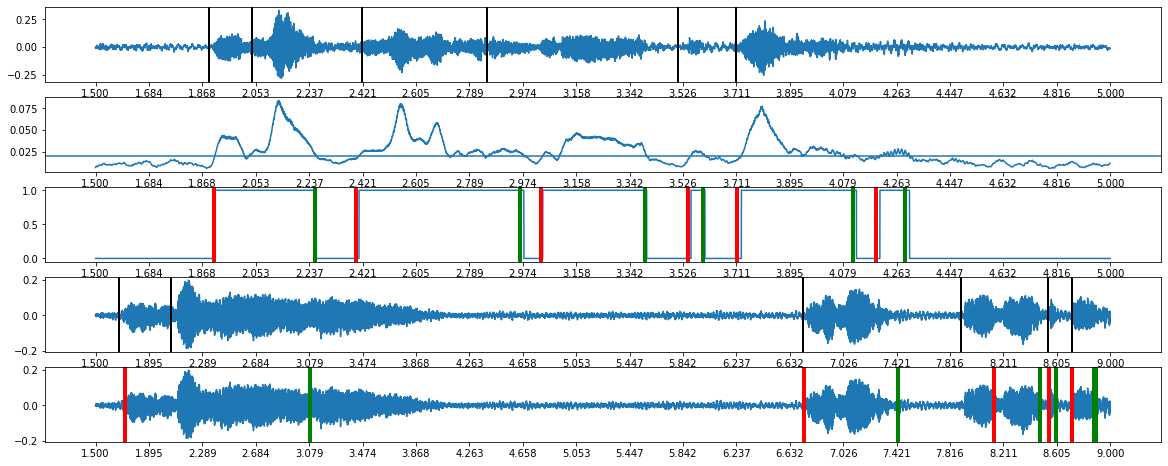

In [424]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 15. normal2combo2

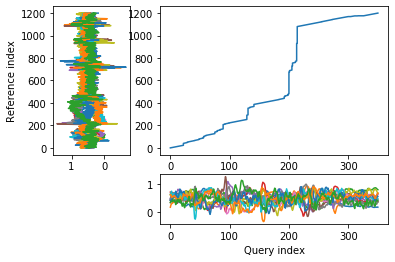

Stretch = 0.83
Distance  = 0.14
Correlation = 0.61


1        2          3        4        5        6        7   \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.90883  2.25783    2.39744  2.96581  3.03561  3.39459  3.54416   
start 2  2.64815  3.40598    4.07407   5.9188   5.9886  6.36752  8.90028   
len 1       0.35     0.14       0.57     0.07     0.36     0.15     0.05   
len 2       0.76     0.67       1.84     0.07     0.38     2.53     0.67   
stretch     0.46     0.74       0.62     0.00     0.04     0.92     0.92   

              8        9        10       11  
seg        pause   projec    pause        t  
start 1  3.59402  3.71368  4.11254  4.19231  
start 2  9.56838   12.849  13.2678  13.3476  
len 1       0.12     0.40     0.08     0.10  
len 2       3.28     0.42     0.08     0.12  
stretch     0.95     0.07     0.00     0.14

1      2          3      4      5      6     7      8       9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  projec   
stretch     0.46   0.74       0.62   0.00   0.04   0.92  0.92   0.95    0.07   

            10    11  
seg      pause     t  
stretch   0.00  0.14

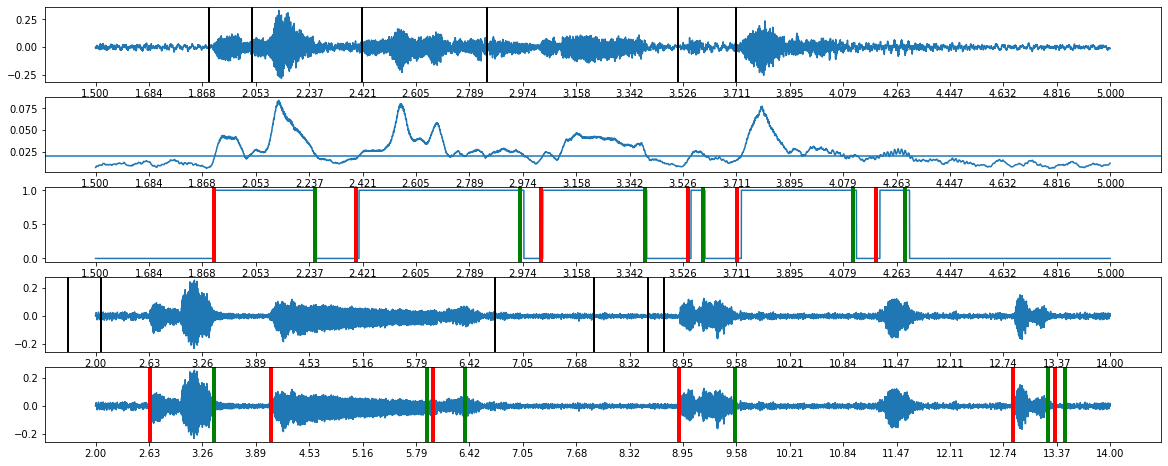

In [425]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal2)

# 16. normal3pause1

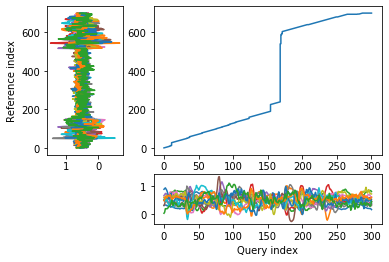

Stretch = 0.91
Distance  = 0.14
Correlation = 0.52


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1   1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  1.98837  2.12791  2.21761  2.34718  2.50664  2.95515  2.98505   
len 1       0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2       0.14     0.09     0.13     0.16     0.45     0.03     0.04   
stretch     0.31     0.00     0.12     0.05     0.10     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  3.02492  3.14452  3.33389  3.77243  3.80233   7.5598   7.7392   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.12     0.19     0.44     0.03     3.76     0.18     0.10   
stretch     0.46     0.00     0.76     0.00     0.95     0.00     0.00   

              15  
seg         ject  
start 1  3.02326  
start 2  7.83887  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.31   0.00  0.12   0.05    0.10   0.00  0.00   0.46   0.00   0.76   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.00   0.95  0.00   0.00  0.00

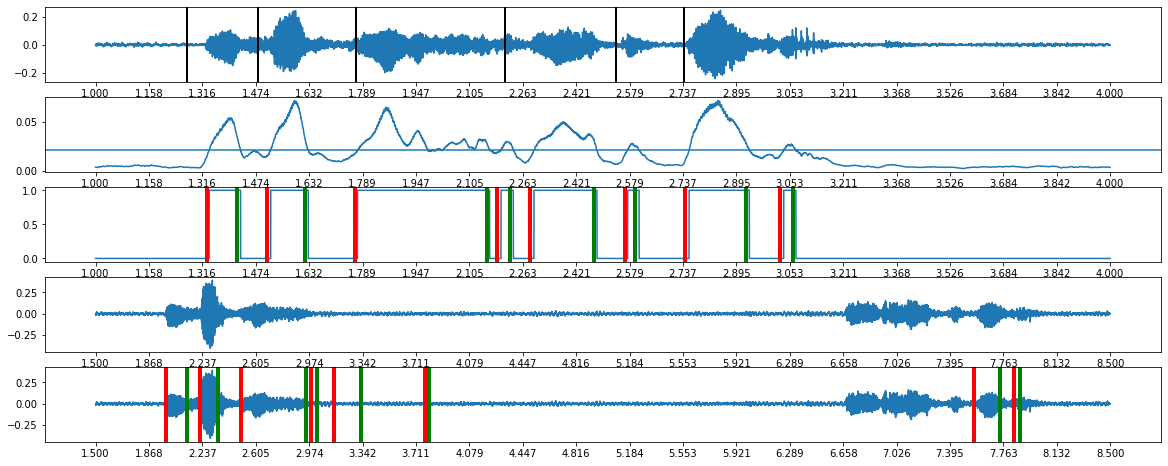

In [448]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 17. normal3pause2

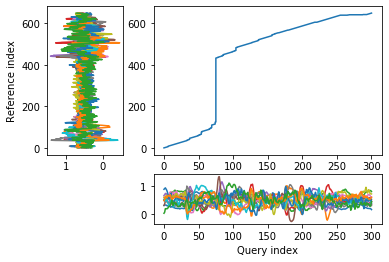

Stretch = 0.87
Distance  = 0.14
Correlation = 0.67


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1   1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  2.34884  2.50831  2.61794  2.85714  6.33555  6.94352  6.97342   
len 1       0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2       0.16     0.11     0.24     3.48     0.61     0.03     0.04   
stretch     0.38     0.15     0.48     0.94     0.29     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  7.01329  7.08306  7.31229  7.44186  7.47176  7.62126   7.7907   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.07     0.23     0.13     0.03     0.15     0.17     0.10   
stretch     0.12     0.14     0.26     0.00     0.10     0.04     0.00   

              15  
seg         ject  
start 1  3.02326  
start 2  7.89037  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.38   0.15  0.48   0.94    0.29   0.00  0.00   0.12   0.14   0.26   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.00   0.10  0.04   0.00  0.00

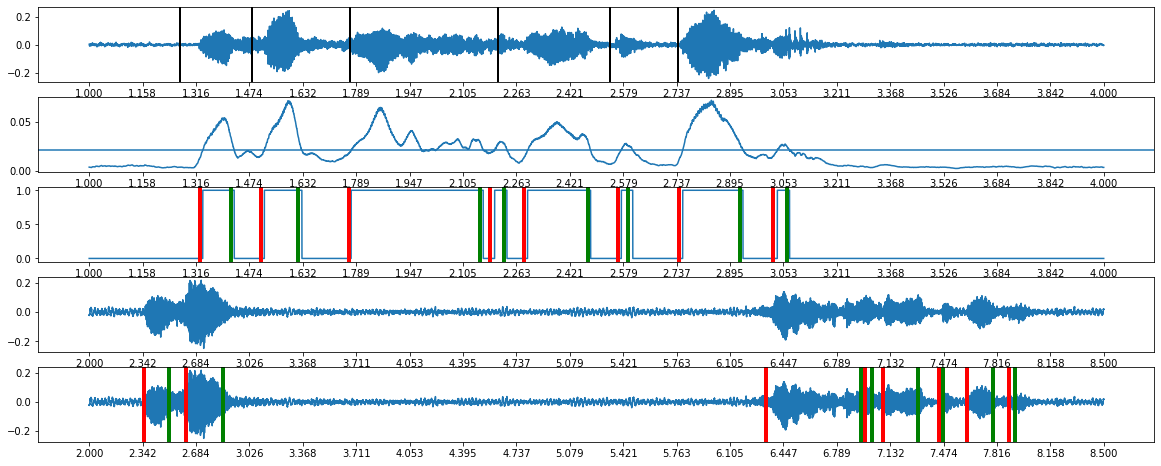

In [427]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 18. normal3longword1

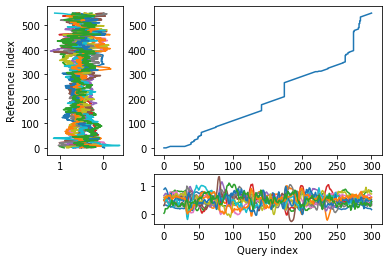

Stretch = 0.38
Distance  = 0.17
Correlation = 0.34


1        2        3        4        5        6        7   \
seg          We    pause     have    pause   really    pause       en   
start 1  1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  1.5897  1.74917  1.97841  2.20764  2.37708  2.76578  2.79568   
len 1      0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2      0.16     0.23     0.23     0.17     0.39     0.03     0.04   
stretch    0.38     0.55     0.46     0.09     0.00     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  2.83555  2.89535  3.32392  3.41362  3.44352  4.16113  4.34053   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.06     0.43     0.09     0.03     0.72     0.18     0.10   
stretch     0.00     0.49     0.00     0.00     0.74     0.00     0.00   

              15  
seg         ject  
start 1  3.02326  
start 2   4.4402  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.38   0.55  0.46   0.09    0.00   0.00  0.00   0.00   0.49   0.00   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.00   0.74  0.00   0.00  0.00

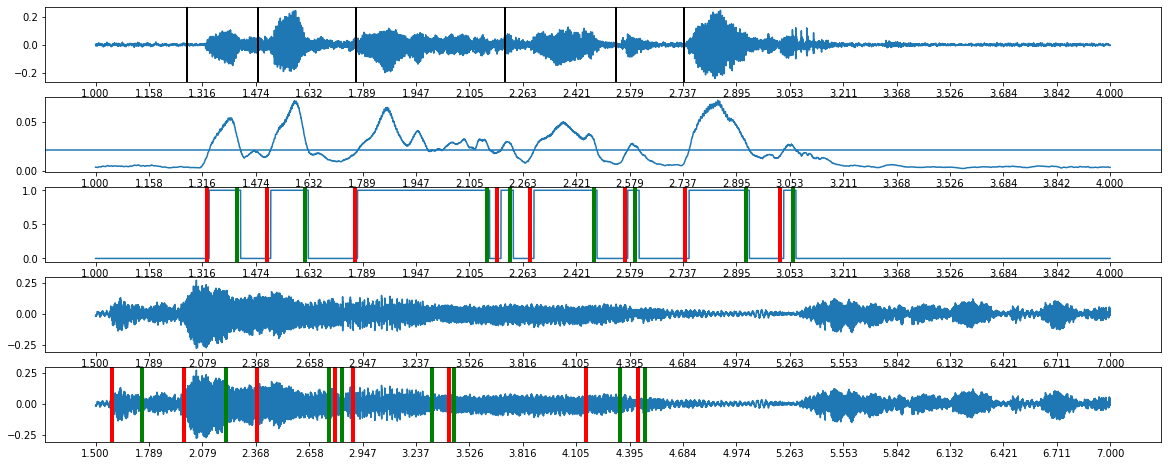

In [428]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 19. normal3longword2

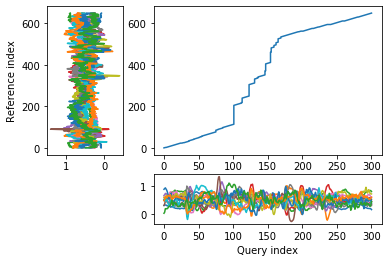

Stretch = 0.66
Distance  = 0.14
Correlation = 0.66


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1   1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  1.78904  1.89867  1.99834  2.13787  2.36711  3.92193  3.95183   
len 1       0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2       0.11     0.10     0.14     0.23     1.55     0.03     0.04   
stretch     0.15     0.08     0.18     0.29     0.69     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  3.99169  4.59967  5.54651  6.32392  6.43355  6.89203  7.07143   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.61     0.95     0.78     0.11     0.46     0.18     0.06   
stretch     0.89     0.75     0.86     0.74     0.61     0.00     0.36   

              15  
seg         ject  
start 1  3.02326  
start 2  7.13123  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.15   0.08  0.18   0.29    0.69   0.00  0.00   0.89   0.75   0.86   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.74   0.61  0.00   0.36  0.00

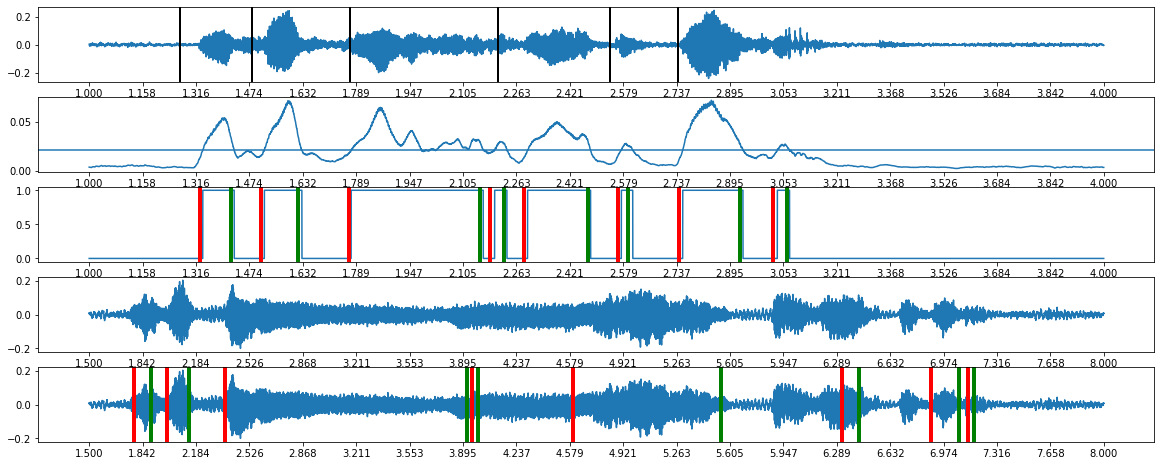

In [429]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 20. normal3combo1

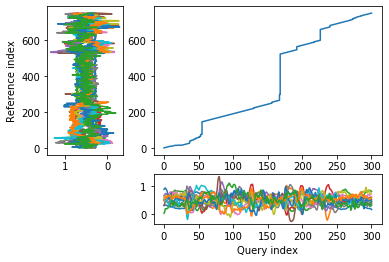

Stretch = 0.87
Distance  = 0.17
Correlation = 0.26


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1   1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  1.71927  1.93854  2.09801  3.01495  3.16445  3.55316  3.58306   
len 1       0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2       0.22     0.16     0.92     0.15     0.39     0.03     0.04   
stretch     0.53     0.38     0.85     0.00     0.00     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  3.62292  3.68272  3.90199  4.04153  4.07143  6.77243  7.12126   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.06     0.22     0.14     0.03     2.70     0.35     0.10   
stretch     0.00     0.11     0.31     0.00     0.93     0.41     0.00   

              15  
seg         ject  
start 1  3.02326  
start 2  7.22093  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.53   0.38  0.85   0.00    0.00   0.00  0.00   0.00   0.11   0.31   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.00   0.93  0.41   0.00  0.00

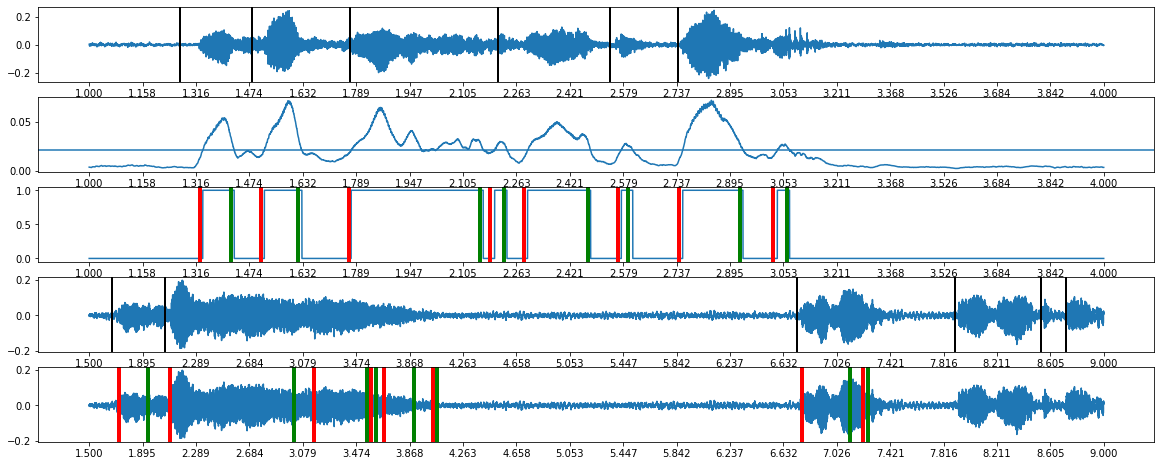

In [430]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, timelst2 = timelst2, segments = segmentsnormal3)

# 21. normal3combo2

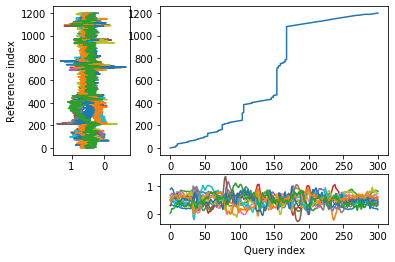

Stretch = 0.88
Distance  = 0.14
Correlation = 0.63


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1   1.3289   1.4186  1.50831  1.61794  1.76744  2.15615  2.18605   
start 2  2.64784  2.80731  3.00664  3.36545  4.08306  5.94684  6.03654   
len 1       0.09     0.09     0.11     0.15     0.39     0.03     0.04   
len 2       0.16     0.20     0.36     0.72     1.86     0.09     0.04   
stretch     0.38     0.49     0.64     0.74     0.73     0.68     0.00   

              8        9        10       11       12       13       14  \
seg        pause    joyed    pause      the    pause      pro    pause   
start 1  2.22591  2.28571  2.47508  2.56478  2.59468  2.74419  2.92359   
start 2  6.07641  6.13621  6.48505  9.26578  9.48505  12.8339  13.0033   
len 1       0.06     0.19     0.09     0.03     0.15     0.18     0.10   
len 2       0.06     0.35     2.78     0.22     3.35     0.17     0.10   
stretch     0.00     0.39     0.96     0.87     0.94     0.04     0.00   

              15  
seg         ject  
start 1  3.02326  
start 2   13.103  
len 1       0.04  
len 2       0.04  
stretch     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.38   0.49  0.64   0.74    0.73   0.68  0.00   0.00   0.39   0.96   

           11     12    13     14    15  
seg       the  pause   pro  pause  ject  
stretch  0.87   0.94  0.04   0.00  0.00

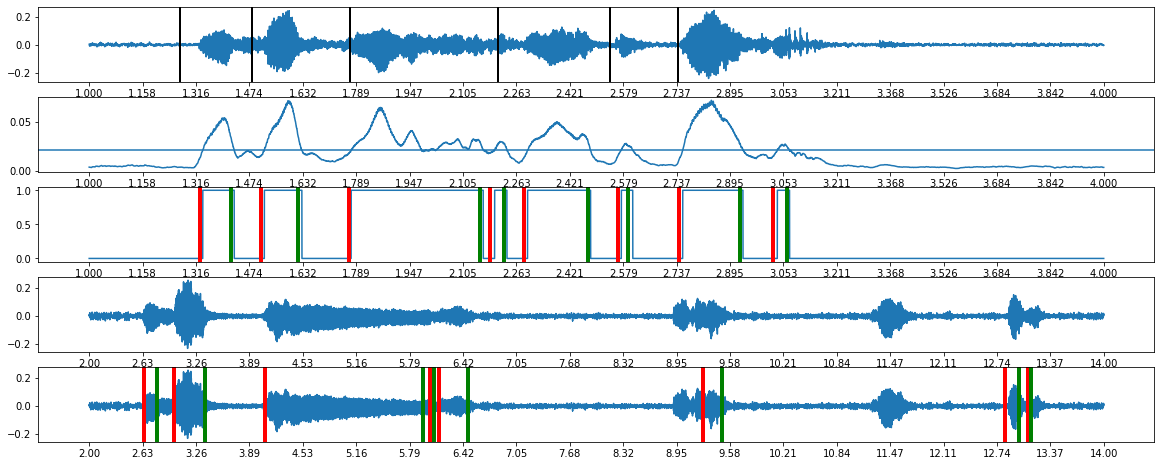

In [431]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021,
      timelst1=timelst1, segments = segmentsnormal3)

# 22. pause1pause2

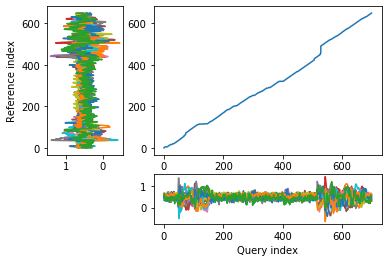

Stretch = 0.16
Distance  = 0.11
Correlation = 0.66


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859    2.898  6.67261  7.25178  7.39158   
start 2   2.3495  2.88873   2.9786  3.15835  6.40371  7.33238  7.45221   
len 1       0.42     0.09     0.41     3.77     0.58     0.14     0.06   
len 2       0.54     0.09     0.18     3.25     0.93     0.12     0.06   
stretch     0.17     0.00     0.46     0.13     0.36     0.11     0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.58131  7.75107  7.85093  
start 2  7.51213  7.65193  7.80171  7.90157  
len 1       0.13     0.17     0.10     0.06  
len 2       0.14     0.15     0.10     0.06  
stretch     0.06     0.09     0.00     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.17   0.00    0.46   0.13     0.36   0.11  0.00   0.06  0.09   

            10    11  
seg      pause  ject  
stretch   0.00  0.00

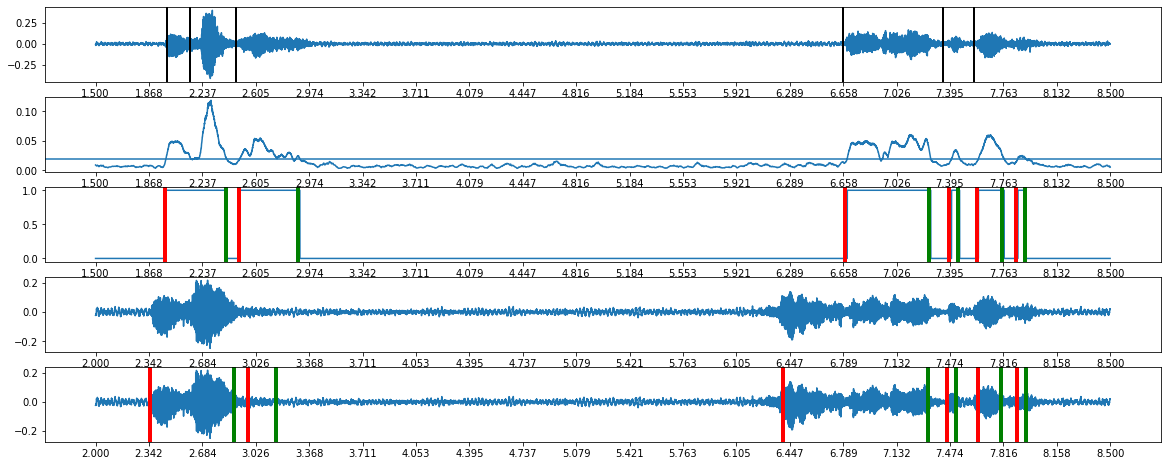

In [432]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 23. pause1longword1

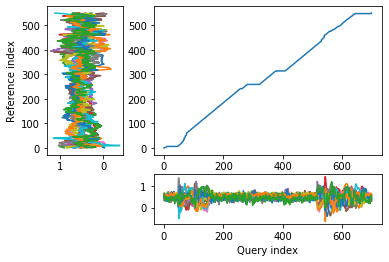

Stretch = 0.15
Distance  = 0.16
Correlation = 0.42


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859    2.898  6.67261  7.25178  7.39158   
start 2  1.57989  2.23894  2.32882  2.73823  5.72397  6.34308  6.45292   
len 1       0.42     0.09     0.41     3.77     0.58     0.14     0.06   
len 2       0.66     0.09     0.41     2.99     0.62     0.11     0.05   
stretch     0.29     0.00     0.00     0.16     0.24     0.11     0.15   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.58131  7.75107  7.85093  
start 2  6.50285  6.64265  6.80243   6.8923  
len 1       0.13     0.17     0.10     0.06  
len 2       0.14     0.16     0.09     0.06  
stretch     0.06     0.05     0.08     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.29   0.00    0.00   0.16     0.24   0.11  0.15   0.06  0.05   

            10    11  
seg      pause  ject  
stretch   0.08  0.00

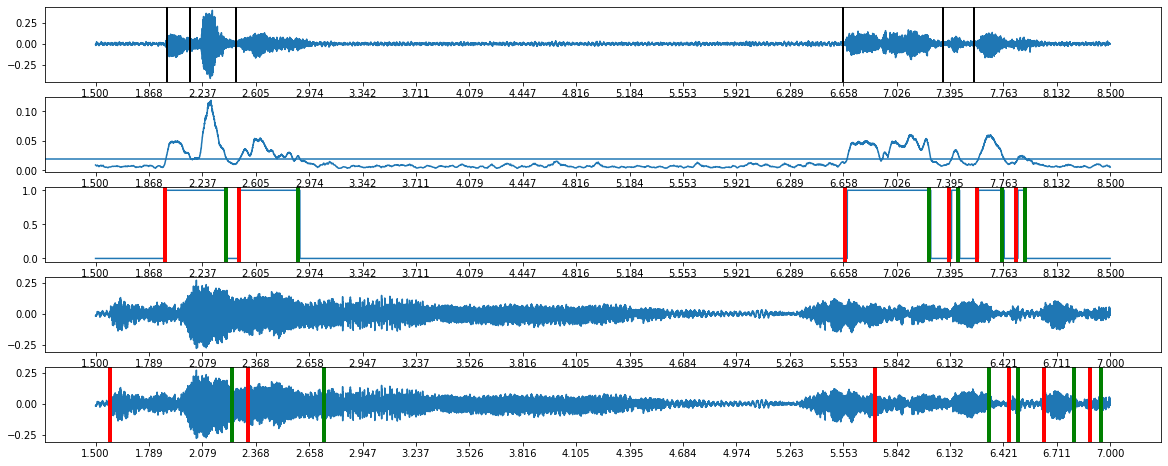

In [433]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 24. pause1longword2

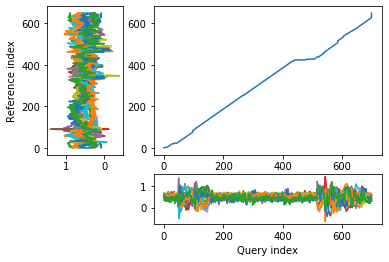

Stretch = 0.04
Distance  = 0.16
Correlation = 0.43


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859    2.898  6.67261  7.25178  7.39158   
start 2  1.76961  2.18902  2.34879  2.76819  5.88374  6.46291  6.69258   
len 1       0.42     0.09     0.41     3.77     0.58     0.14     0.06   
len 2       0.42     0.16     0.42     3.12     0.58     0.23     0.06   
stretch     0.00     0.38     0.02     0.13     0.10     0.33     0.00   

             8        9        10       11  
seg       pause      pro    pause     ject  
start 1  7.4515  7.58131  7.75107  7.85093  
start 2  6.7525  6.91227  7.06205  7.14194  
len 1      0.13     0.17     0.10     0.06  
len 2      0.16     0.15     0.08     0.06  
stretch    0.15     0.09     0.17     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.00   0.38    0.02   0.13     0.10   0.33  0.00   0.15  0.09   

            10    11  
seg      pause  ject  
stretch   0.17  0.00

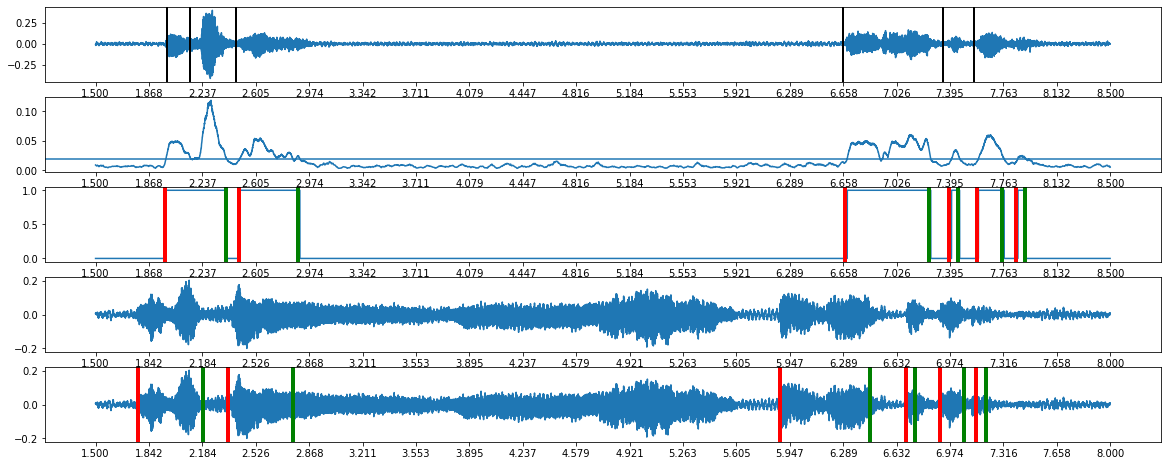

In [434]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 25. pause1combo1

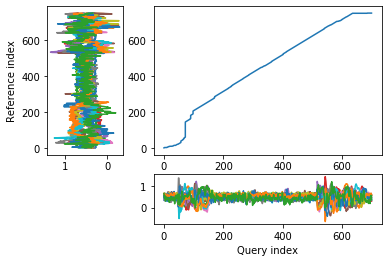

Stretch = 0.11
Distance  = 0.14
Correlation = 0.48


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859    2.898  6.67261  7.25178  7.39158   
start 2   1.7097  3.13766  3.55706  3.96648  7.89087  8.46006  8.54993   
len 1       0.42     0.09     0.41     3.77     0.58     0.14     0.06   
len 2       1.43     0.42     0.41     3.92     0.57     0.09     0.03   
stretch     0.64     0.74     0.00     0.04     0.06     0.31     0.51   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.58131  7.75107  7.85093  
start 2  8.57989  8.71969  8.87946  8.97932  
len 1       0.13     0.17     0.10     0.06  
len 2       0.14     0.16     0.10     0.00  
stretch     0.06     0.05     0.00     1.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.64   0.74    0.00   0.04     0.06   0.31  0.51   0.06  0.05   

            10    11  
seg      pause  ject  
stretch   0.00  1.00

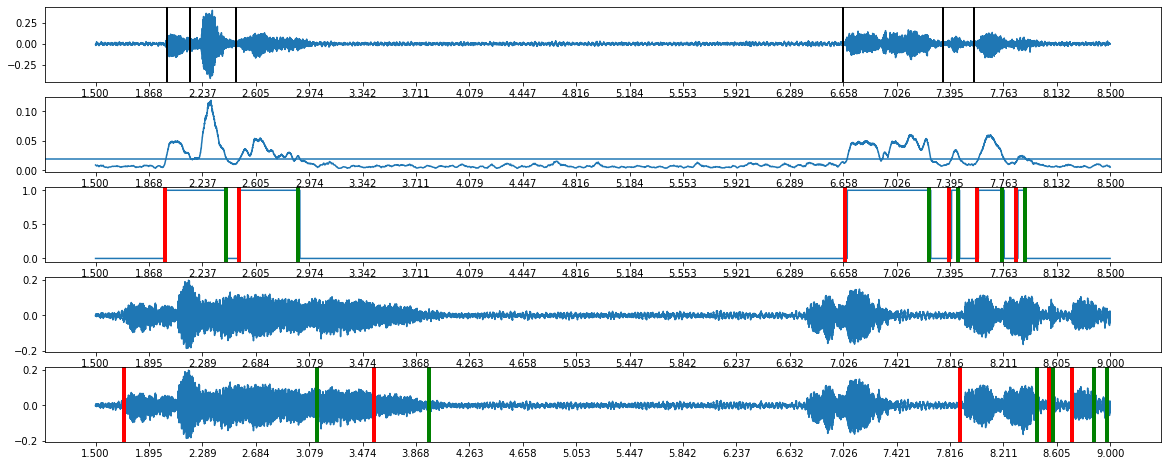

In [435]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 26. pause1combo2

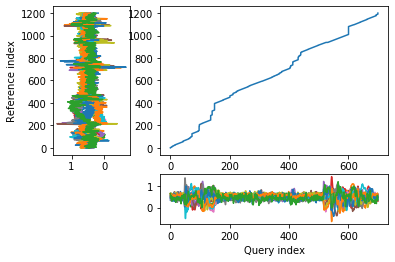

Stretch = 0.39
Distance  = 0.13
Correlation = 0.59


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.97932  2.39872  2.48859    2.898  6.67261  7.25178  7.39158   
start 2  2.64907  3.42796  4.07703  4.91583  11.3167   11.826  11.9658   
len 1       0.42     0.09     0.41     3.77     0.58     0.14     0.06   
len 2       0.78     0.65     0.84     6.40     0.51     0.14     0.06   
stretch     0.38     0.83     0.43     0.34     0.09     0.00     0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1   7.4515  7.58131  7.75107  7.85093  
start 2  12.0257  12.8645  13.0143  13.1241  
len 1       0.13     0.17     0.10     0.06  
len 2       0.84     0.15     0.11     0.07  
stretch     0.81     0.09     0.07     0.12

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
stretch     0.38   0.83    0.43   0.34     0.09   0.00  0.00   0.81  0.09   

            10    11  
seg      pause  ject  
stretch   0.07  0.12

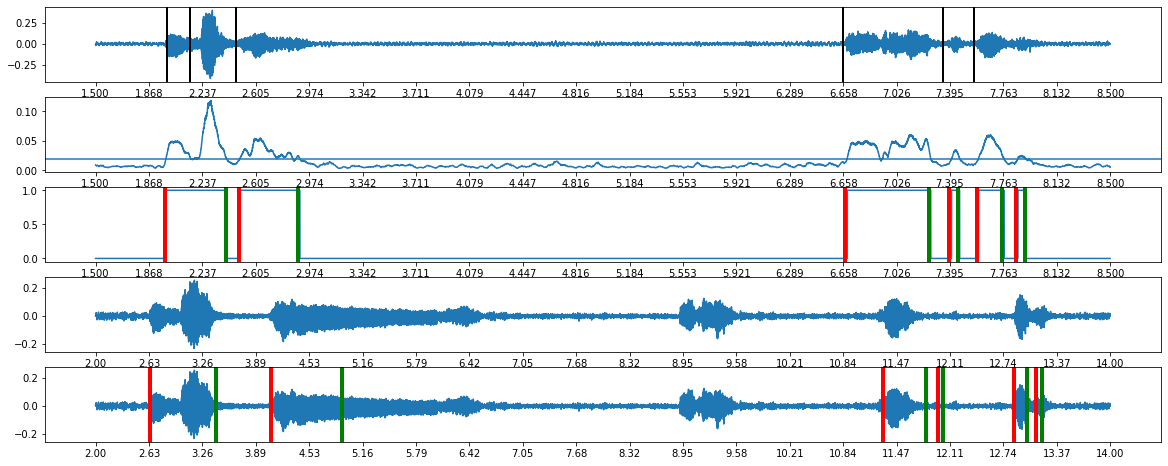

In [436]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause1)

# 27. pause2longword1

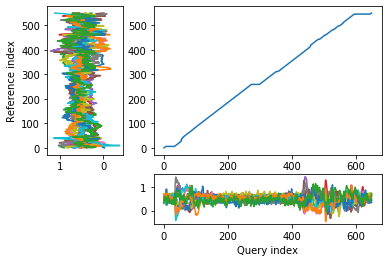

Stretch = 0.06
Distance  = 0.14
Correlation = 0.53


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  2.35945  2.52919  2.56912  2.87865  6.36329  6.65284  6.71275   
start 2  1.58986  1.76959  1.87942  2.21889  5.40399  5.75346  5.81336   
len 1       0.17     0.04     0.31     3.48     0.29     0.06     0.06   
len 2       0.18     0.11     0.34     3.19     0.35     0.06     0.06   
stretch     0.04     0.62     0.07     0.07     0.13     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1  6.77266  6.83257  7.02227  7.08218   7.3318   7.4616  7.50154   
start 2  5.87327   5.9232  6.08295  6.12289  6.34255  6.47235  6.48233   
len 1       0.06     0.19     0.06     0.25     0.13     0.04     0.13   
len 2       0.05     0.16     0.04     0.22     0.13     0.01     0.15   
stretch     0.00     0.12     0.32     0.09     0.00     1.00     0.11   

              15       16       17  
seg          pro    pause     ject  
start 1  7.63134  7.78111  7.94086  
start 2   6.6321  6.78187  6.94163  
len 1       0.15     0.16     0.03  
len 2       0.15     0.16     0.01  
stretch     0.00     0.00     1.00

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.04   0.62  0.07   0.07  0.13   0.00  0.00   0.00  0.12   0.32   

            11     12    13     14    15     16    17  
seg      joyed  pause   the  pause   pro  pause  ject  
stretch   0.09   0.00  1.00   0.11  0.00   0.00  1.00

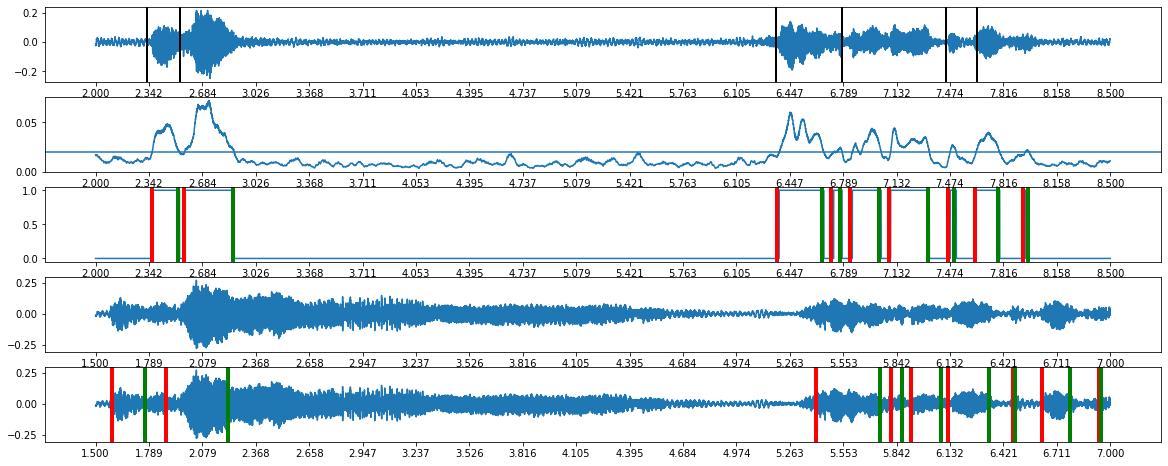

In [437]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1.5, 7

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause2)

# 28. pause2longword2

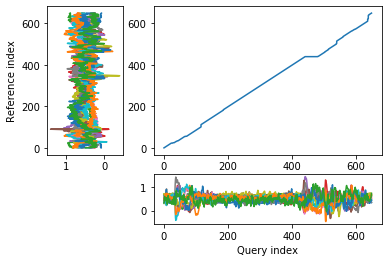

Stretch = 0.05
Distance  = 0.16
Correlation = 0.34


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  2.35945  2.52919  2.56912  2.87865  6.36329  6.65284  6.71275   
start 2  1.78955  1.92934  1.96928  2.22888  5.84332  5.89324  5.89324   
len 1       0.17     0.04     0.31     3.48     0.29     0.06     0.06   
len 2       0.14     0.04     0.26     3.61     0.05     0.00     0.00   
stretch     0.14     0.00     0.12     0.03     0.76     1.00     1.00   

              8        9        10       11      12      13       14       15  \
seg        pause       en    pause    joyed   pause     the    pause      pro   
start 1  6.77266  6.83257  7.02227  7.08218  7.3318  7.4616  7.50154  7.63134   
start 2  5.89324  5.91321  6.10292  6.17281  6.4424   6.702  6.74194  6.89171   
len 1       0.06     0.19     0.06     0.25    0.13    0.04     0.13     0.15   
len 2       0.02     0.19     0.07     0.27    0.26    0.04     0.15     0.15   
stretch     0.74     0.00     0.12     0.06    0.43    0.00     0.11     0.00   

              16       17  
seg        pause     ject  
start 1  7.78111  7.94086  
start 2  7.04147  7.19124  
len 1       0.16     0.03  
len 2       0.15     0.02  
stretch     0.05     0.41

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.14   0.00  0.12   0.03  0.76   1.00  1.00   0.74  0.00   0.12   

            11     12    13     14    15     16    17  
seg      joyed  pause   the  pause   pro  pause  ject  
stretch   0.06   0.43  0.00   0.11  0.00   0.05  0.41

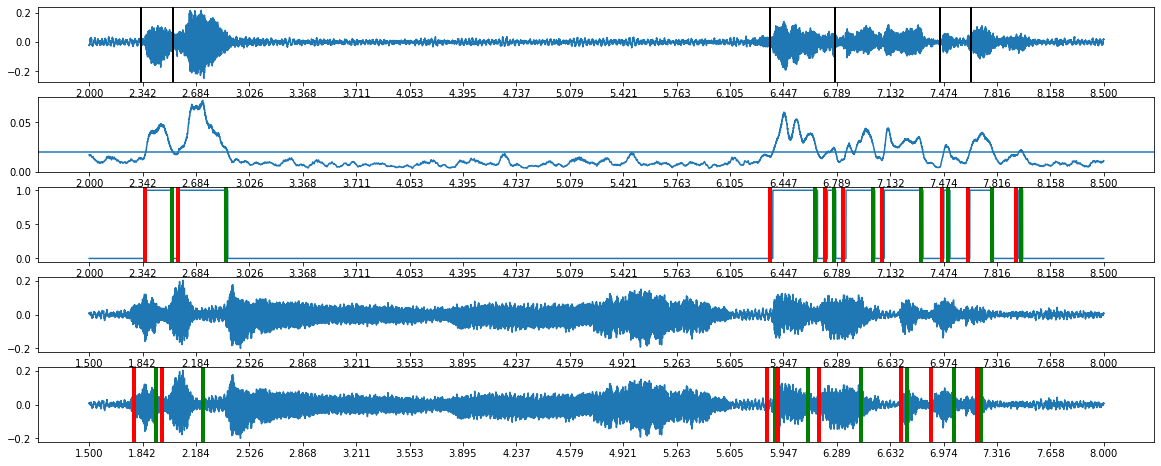

In [438]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause2)

# 29. pause2combo1

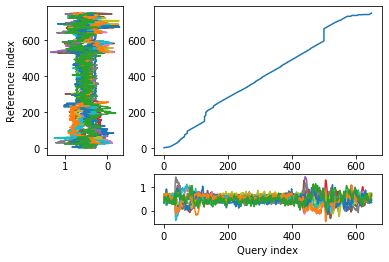

Stretch = 0.21
Distance  = 0.13
Correlation = 0.61


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  2.35945  2.52919  2.56912  2.87865  6.36329  6.65284  6.71275   
start 2  1.72965  1.96928  2.03917  2.57834  6.77189   7.0914  7.15131   
len 1       0.17     0.04     0.31     3.48     0.29     0.06     0.06   
len 2       0.24     0.07     0.54     4.19     0.32     0.06     0.06   
stretch     0.24     0.41     0.35     0.13     0.07     0.00     0.00   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1  6.77266  6.83257  7.02227  7.08218   7.3318   7.4616  7.50154   
start 2  7.21121  7.27112  8.13978  8.19969  8.44931  8.55914  8.57911   
len 1       0.06     0.19     0.06     0.25     0.13     0.04     0.13   
len 2       0.06     0.87     0.06     0.25     0.11     0.02     0.13   
stretch     0.00     0.73     0.00     0.00     0.12     0.26     0.11   

              15       16       17  
seg          pro    pause     ject  
start 1  7.63134  7.78111  7.94086  
start 2  8.70891  8.80876  8.85868  
len 1       0.15     0.16     0.03  
len 2       0.10     0.05     0.00  
stretch     0.22     0.59     1.00

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.24   0.41  0.35   0.13  0.07   0.00  0.00   0.00  0.73   0.00   

            11     12    13     14    15     16    17  
seg      joyed  pause   the  pause   pro  pause  ject  
stretch   0.00   0.12  0.26   0.11  0.22   0.59  1.00

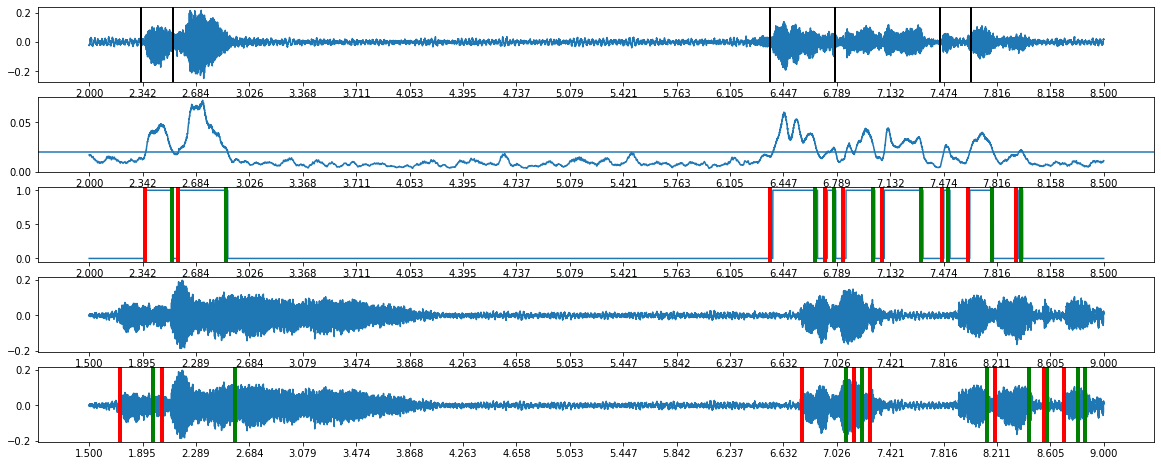

In [439]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause2)

# 30. pause2combo2

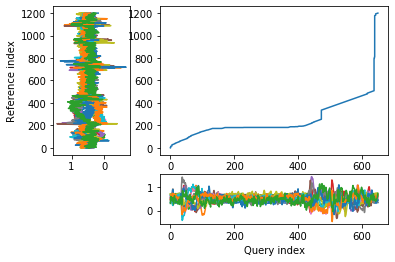

Stretch = 0.67
Distance  = 0.13
Correlation = 0.55


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  2.35945  2.52919  2.56912  2.87865  6.36329  6.65284  6.71275   
start 2  2.65899  2.82873   2.9086  3.31797  4.12673  4.46621  4.52611   
len 1       0.17     0.04     0.31     3.48     0.29     0.06     0.06   
len 2       0.17     0.08     0.41     0.81     0.34     0.06     0.88   
stretch     0.00     0.49     0.19     0.72     0.11     0.00     0.92   

              8        9        10       11      12      13       14       15  \
seg        pause       en    pause    joyed   pause     the    pause      pro   
start 1  6.77266  6.83257  7.02227  7.08218  7.3318  7.4616  7.50154  7.63134   
start 2  5.40476  5.46467  5.65438  5.71429  5.9639  6.0937  6.13364  6.26344   
len 1       0.06     0.19     0.06     0.25    0.13    0.04     0.13     0.15   
len 2       0.06     0.19     0.06     0.25    0.13    0.04     0.13     0.15   
stretch     0.00     0.00     0.00     0.00    0.00    0.00     0.00     0.00   

              16       17  
seg        pause     ject  
start 1  7.78111  7.94086  
start 2  6.41321  6.57296  
len 1       0.16     0.03  
len 2       0.16     0.03  
stretch     0.00     0.00

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.00   0.49  0.19   0.72  0.11   0.00  0.92   0.00  0.00   0.00   

            11     12    13     14    15     16    17  
seg      joyed  pause   the  pause   pro  pause  ject  
stretch   0.00   0.00  0.00   0.00  0.00   0.00  0.00

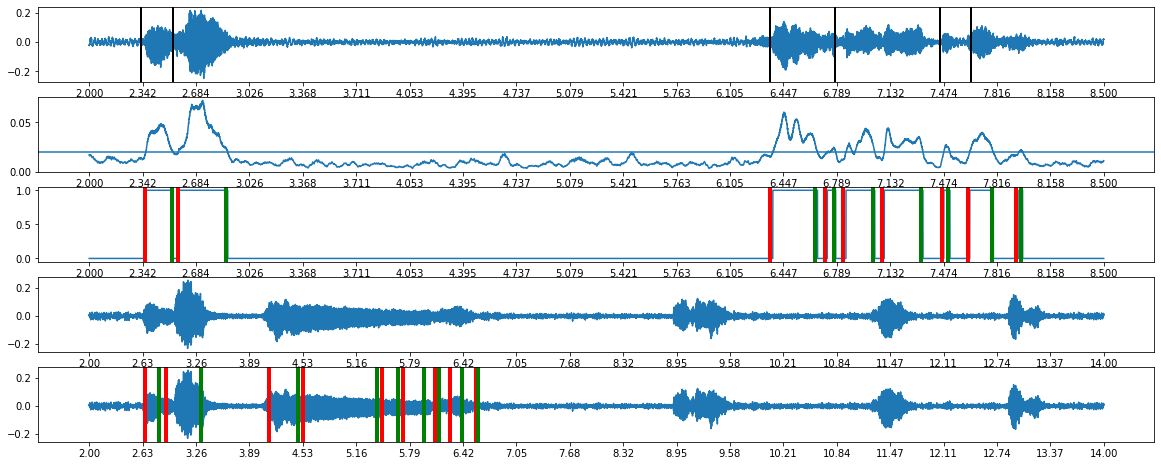

In [440]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 2, 8.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause2)

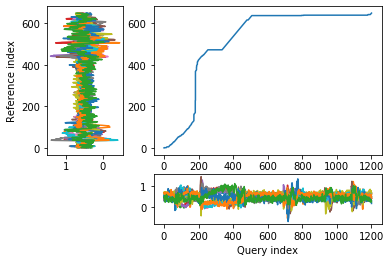

IndexError: list index out of range

In [441]:
file1, seg1_1, seg1_2 = "report-combo2.wav", 2, 14
file2, seg2_1, seg2_2 = "report-pause2.wav", 2, 8.5

timelst1 = [2.33, 2.54, 6.36, 6.78, 7.45, 7.65]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.02,
      timelst1=timelst1, segments = segmentspause2)

# 31. longword1longword2

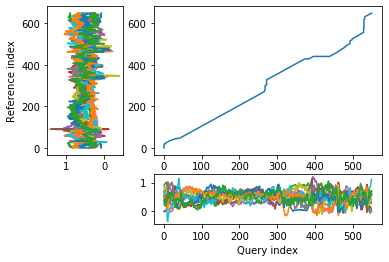

Stretch = 0.12
Distance  = 0.17
Correlation = 0.37


1        2        3        4        5        6        7   \
seg      We have    pause    pause    pause    pause    pause   really   
start 1  1.56987  4.40472  4.44465  4.56443   5.0735  5.12341  5.32305   
start 2  1.75953   4.9637  5.00363  5.12341  5.63249   5.6824  5.78221   
len 1       2.83     0.04     0.12     0.51     0.05     0.20     0.55   
len 2       3.20     0.04     0.12     0.51     0.05     0.10     0.12   
stretch     0.15     0.00     0.00     0.00     0.00     0.39     0.71   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1  5.87205  5.91198  6.09165  6.13158  6.35118    6.451  6.50091   
start 2    5.902  5.93194  6.11162  6.17151    6.451  6.68058  6.77042   
len 1       0.04     0.18     0.04     0.22     0.10     0.05     0.11   
len 2       0.03     0.18     0.06     0.28     0.23     0.09     0.11   
stretch     0.26     0.00     0.32     0.17     0.51     0.41     0.00   

              15       16       17  
seg          pro    pause     ject  
start 1  6.61071  6.80036  6.92015  
start 2  6.88022  7.68875  7.91833  
len 1       0.19     0.12     0.04  
len 2       0.81     0.23     0.04  
stretch     0.71     0.41     0.00

1      2      3      4      5      6       7      8     9   \
seg      We have  pause  pause  pause  pause  pause  really  pause    en   
stretch     0.15   0.00   0.00   0.00   0.00   0.39    0.71   0.26  0.00   

            10     11     12    13     14    15     16    17  
seg      pause  joyed  pause   the  pause   pro  pause  ject  
stretch   0.32   0.17   0.51  0.41   0.00  0.71   0.41  0.00

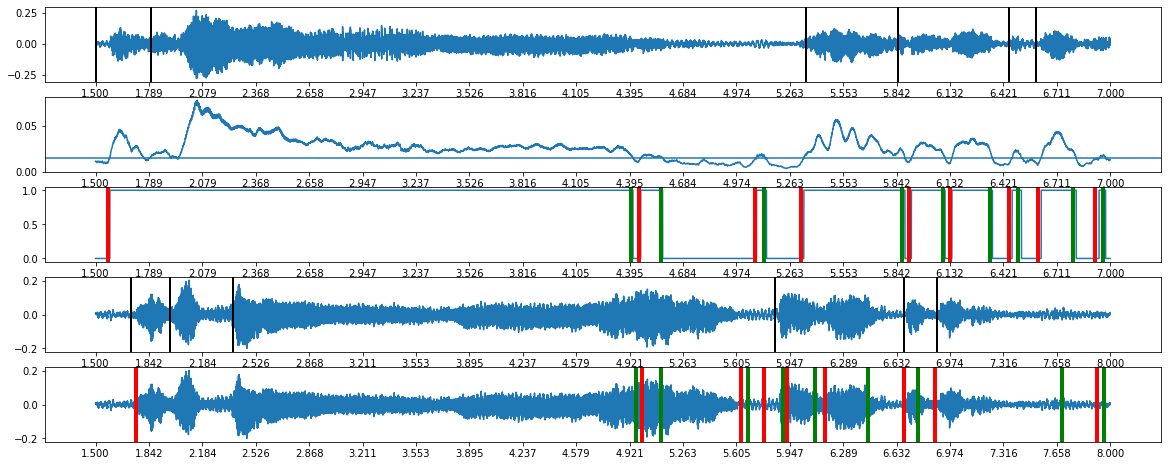

In [442]:
segmentslongword1 = ['We have', 'pause', 'pause', 'pause', 'pause', 'pause', 'really', 'pause', 'en', 'pause', 'joyed', 'pause', 'the', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '']

file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 32. longword1combo1

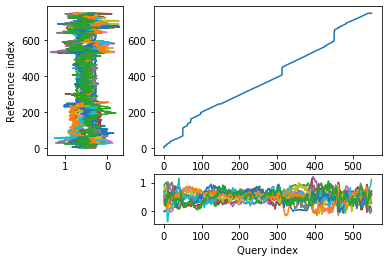

Stretch = 0.32
Distance  = 0.13
Correlation = 0.64


1        2        3        4        5        6        7   \
seg      We have    pause    pause    pause    pause    pause   really   
start 1  1.56987  4.40472  4.44465  4.56443   5.0735  5.12341  5.32305   
start 2  1.65971  5.33303  5.37296  5.49274  6.43103  6.48094  6.69056   
len 1       2.83     0.04     0.12     0.51     0.05     0.20     0.55   
len 2       3.67     0.04     0.12     0.94     0.05     0.21     0.60   
stretch     0.20     0.00     0.00     0.38     0.00     0.04     0.09   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1  5.87205  5.91198  6.09165  6.13158  6.35118    6.451  6.50091   
start 2  7.28947   7.3294  8.13793  8.19782  8.45735  8.54719  8.58711   
len 1       0.04     0.18     0.04     0.22     0.10     0.05     0.11   
len 2       0.04     0.81     0.06     0.26     0.09     0.04     0.10   
stretch     0.00     0.72     0.32     0.12     0.08     0.00     0.07   

              15       16       17  
seg          pro    pause     ject  
start 1  6.61071  6.80036  6.92015  
start 2  8.68693  8.87659  8.97641  
len 1       0.19     0.12     0.04  
len 2       0.19     0.10     0.00  
stretch     0.00     0.07     1.00

1      2      3      4      5      6       7      8     9   \
seg      We have  pause  pause  pause  pause  pause  really  pause    en   
stretch     0.20   0.00   0.00   0.38   0.00   0.04    0.09   0.00  0.72   

            10     11     12    13     14    15     16    17  
seg      pause  joyed  pause   the  pause   pro  pause  ject  
stretch   0.32   0.12   0.08  0.00   0.07  0.00   0.07  1.00

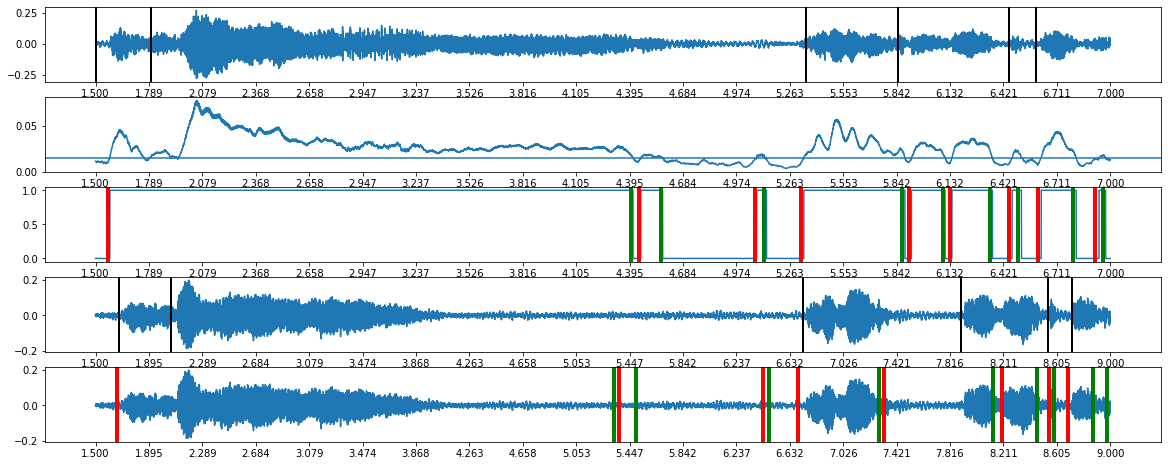

In [443]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 33. longword1combo2

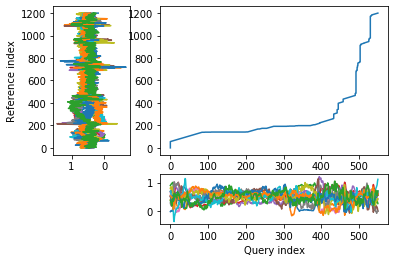

Stretch = 0.69
Distance  = 0.16
Correlation = 0.55


1        2        3        4        5        6        7   \
seg      We have    pause    pause    pause    pause    pause   really   
start 1  1.56987  4.40472  4.44465  4.56443   5.0735  5.12341  5.32305   
start 2  2.62886  3.91652  3.91652  3.91652  3.97641  3.97641  4.05626   
len 1       2.83     0.04     0.12     0.51     0.05     0.20     0.55   
len 2       1.29     0.00     0.00     0.06     0.00     0.08     1.00   
stretch     0.46     1.00     1.00     0.84     1.00     0.49     0.39   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1  5.87205  5.91198  6.09165  6.13158  6.35118    6.451  6.50091   
start 2  5.05445  5.09437  6.35209  6.39201  6.61162  9.15699  9.57623   
len 1       0.04     0.18     0.04     0.22     0.10     0.05     0.11   
len 2       0.04     1.26     0.04     0.22     2.55     0.42     1.72   
stretch     0.00     0.82     0.00     0.00     0.95     0.87     0.92   

              15       16       17  
seg          pro    pause     ject  
start 1  6.61071  6.80036  6.92015  
start 2  11.2931  13.6987  13.9083  
len 1       0.19     0.12     0.04  
len 2       2.41     0.21     0.04  
stretch     0.90     0.37     0.00

1      2      3      4      5      6       7      8     9   \
seg      We have  pause  pause  pause  pause  pause  really  pause    en   
stretch     0.46   1.00   1.00   0.84   1.00   0.49    0.39   0.00  0.82   

            10     11     12    13     14    15     16    17  
seg      pause  joyed  pause   the  pause   pro  pause  ject  
stretch   0.00   0.00   0.95  0.87   0.92  0.90   0.37  0.00

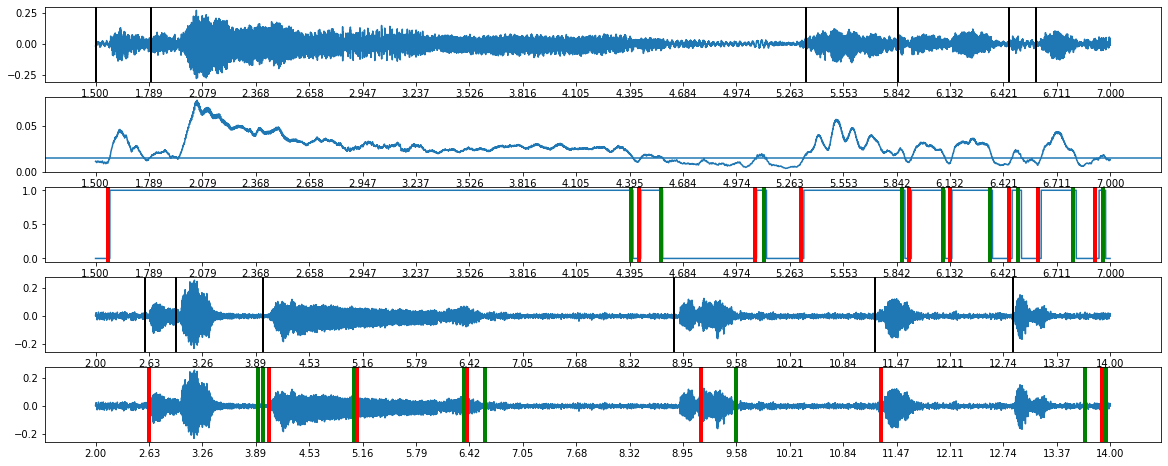

In [444]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1.5, 7
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword1)

# 34. longword2combo1

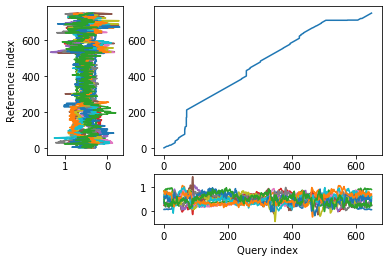

Stretch = 0.34
Distance  = 0.16
Correlation = 0.39


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  1.77957  1.92934  2.00922    2.149  2.36866  2.82796  3.84639   
start 2  1.71966  1.96928  2.10906  2.25883  3.76651  4.22581  5.24424   
len 1       0.15     0.08     0.14     0.22     0.46     1.02     1.62   
len 2       0.25     0.14     0.15     1.51     0.46     1.02     2.08   
stretch     0.34     0.38     0.05     0.81     0.00     0.00     0.17   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1   5.4639  5.86329  6.10292  6.17281  6.46237  6.69201  6.78187   
start 2  7.32104  7.88018   8.1298  8.18971  8.48925  8.58909  8.58909   
len 1       0.40     0.24     0.07     0.29     0.23     0.09     0.12   
len 2       0.56     0.25     0.06     0.30     0.10     0.00     0.00   
stretch     0.22     0.03     0.12     0.07     0.46     1.00     1.00   

              15  
seg          pro  
start 1  6.90169  
start 2  8.58909  
len 1       0.12  
len 2       0.00  
stretch     1.00

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.34   0.38  0.05   0.81  0.00   0.00  0.17   0.22  0.03   0.12   

            11     12    13     14    15  
seg      joyed  pause   the  pause   pro  
stretch   0.07   0.46  1.00   1.00  1.00

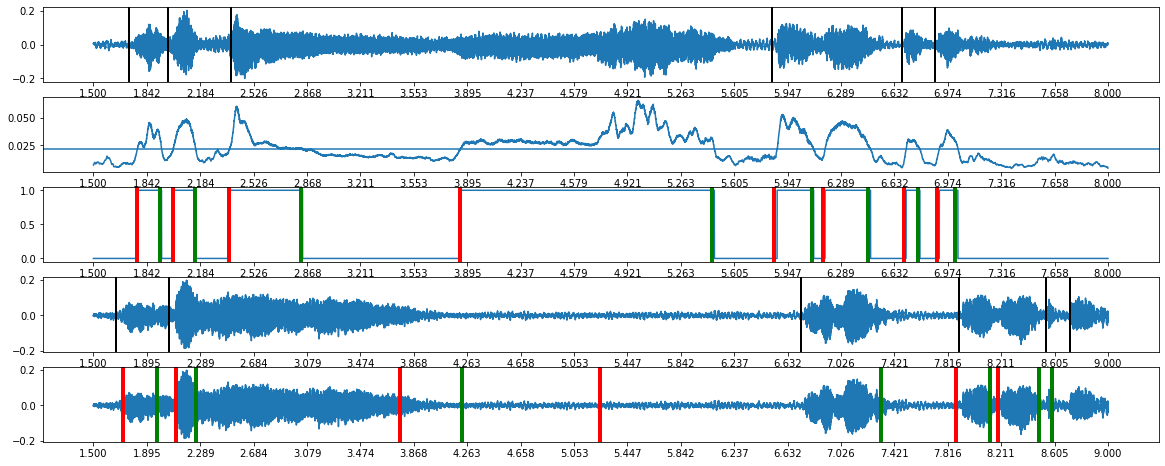

In [445]:
file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo1.wav", 1.5, 9

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.022, timelst2=timelst2,
      timelst1=timelst1, segments = segmentspause2)

# 35. longword2combo2

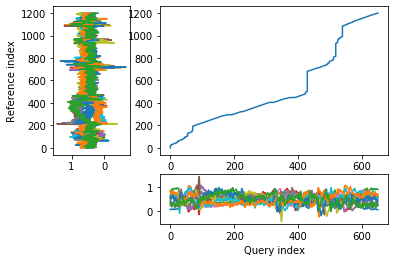

Stretch = 0.52
Distance  = 0.13
Correlation = 0.72


1        2        3        4        5        6        7   \
seg           We    pause     have    pause      rea    pause      lly   
start 1  1.77957  1.92934  2.00922    2.149  2.36866  2.82796  3.84639   
start 2    2.649  2.85868  3.01843  3.39785  4.09677  4.55607  5.30492   
len 1       0.15     0.08     0.14     0.22     0.46     1.02     1.62   
len 2       0.21     0.16     0.38     0.70     0.46     0.75     1.23   
stretch     0.23     0.45     0.57     0.62     0.00     0.21     0.18   

              8        9        10       11       12       13       14  \
seg        pause       en    pause    joyed    pause      the    pause   
start 1   5.4639  5.86329  6.10292  6.17281  6.46237  6.69201  6.78187   
start 2  6.53303  8.87942  9.08909  9.15899  9.55837  11.3157  11.6951   
len 1       0.40     0.24     0.07     0.29     0.23     0.09     0.12   
len 2       2.35     0.21     0.07     0.40     1.76     0.38     1.15   
stretch     0.78     0.06     0.00     0.22     0.83     0.72     0.87   

              15  
seg          pro  
start 1  6.90169  
start 2  12.8433  
len 1       0.12  
len 2       0.13  
stretch     0.06

1      2     3      4     5      6     7      8     9      10  \
seg        We  pause  have  pause   rea  pause   lly  pause    en  pause   
stretch  0.23   0.45  0.57   0.62  0.00   0.21  0.18   0.78  0.06   0.00   

            11     12    13     14    15  
seg      joyed  pause   the  pause   pro  
stretch   0.22   0.83  0.72   0.87  0.06

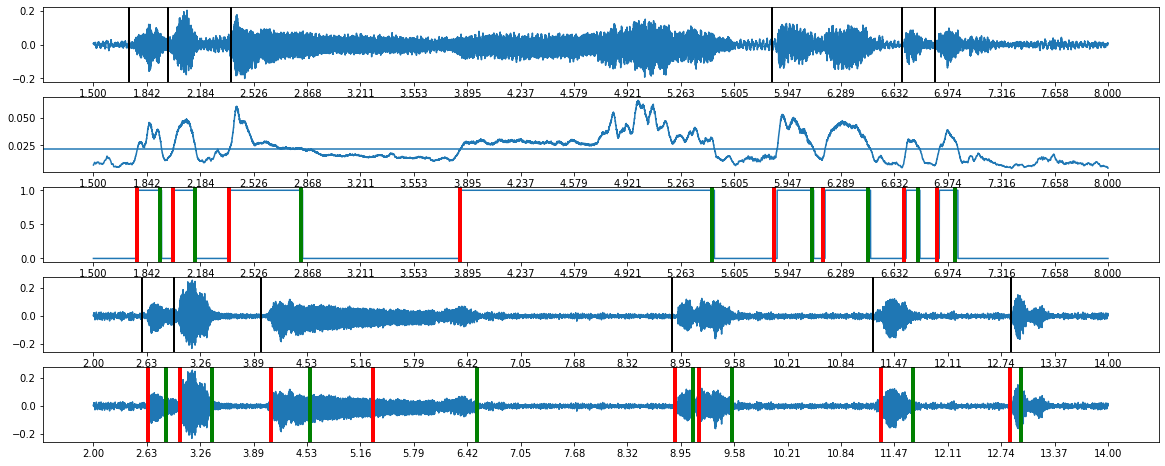

In [446]:
file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.022, timelst2=timelst2,
      timelst1=timelst1, segments = segmentspause2)

# 36. combo1combo2

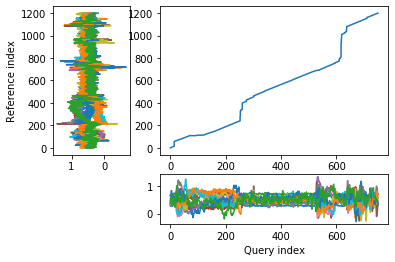

Stretch = 0.50
Distance  = 0.15
Correlation = 0.41


1        2        3        4        5        6        7   \
seg           We    pause     have    pause   really    pause       en   
start 1  1.72969  1.93941   2.0992  3.55726    6.753  7.29228  7.91145   
start 2  2.66911  2.83888  2.99867  3.93742  8.88083  9.37017  12.8256   
len 1       0.21     0.16     1.46     3.20     0.54     0.62     0.22   
len 2       0.17     0.16     0.94     4.94     0.49     3.46     0.22   
stretch     0.15     0.00     0.28     0.30     0.12     0.77     0.00   

              8        9        10       11       12       13  
seg        pause    joyed    pause      the    pause  project  
start 1  8.13116  8.20107  8.46072   8.5506  8.57057  8.71039  
start 2  13.0453  13.1152  13.3748  13.4647  13.4847  13.7044  
len 1       0.07     0.26     0.09     0.02     0.14     0.16  
len 2       0.07     0.26     0.09     0.02     0.22     0.16  
stretch     0.00     0.00     0.00     0.00     0.30     0.00

1      2     3      4       5      6     7      8      9      10  \
seg        We  pause  have  pause  really  pause    en  pause  joyed  pause   
stretch  0.15   0.00  0.28   0.30    0.12   0.77  0.00   0.00   0.00   0.00   

           11     12       13  
seg       the  pause  project  
stretch  0.00   0.30     0.00

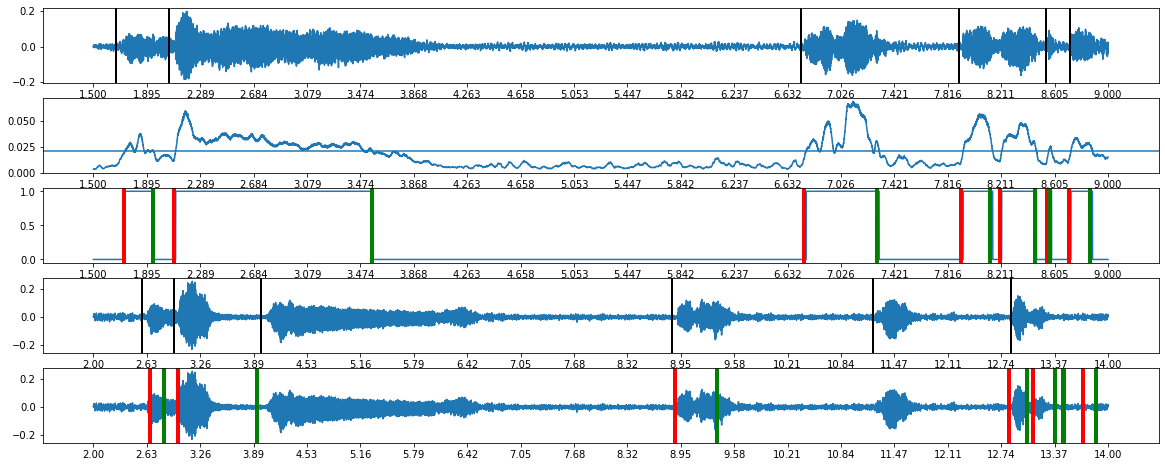

In [447]:
file1, seg1_1, seg1_2 = "report-combo1.wav", 1.5, 9
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, input_min_pause = 30, threshold1 = 0.021, timelst2=timelst2,
      timelst1=timelst1, segments = segmentscombo1)